### Imports

In [1]:
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import HBox,VBox
import plotly.figure_factory as ff
import plotly.offline as plt_off
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import ChainMap
from joblib import Parallel, delayed
import seaborn as sns
import os
import sklearn.cluster as cluster
from collections import defaultdict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
#from statannot import add_stat_annotation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
#import lightgbm as lgb
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.covariance import EmpiricalCovariance, MinCovDet
import networkx as nx
from networkx.algorithms.approximation import clique as clq
import random
from scipy.optimize import curve_fit
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, as_float_array
from sklearn.base import TransformerMixin, BaseEstimator
#import kneed
#import scipy
from functools import partial
#from zca import ZCA, ZCA_corr
#from combat.pycombat import pycombat
#from pycombat import Combat
from IPython.display import display
#import time
#import psutil

import warnings
warnings.filterwarnings('ignore')

### Definition of essential functions

Functions for outlier removal and normalization

In [2]:
def remove_outliers_by_plate(df_in, sigma, method, neg, pos, pro):

    list_df_plate = []

    df_in['Plate2'] = df_in.index.get_level_values('Plate')

    for plate in np.unique(df_in['Plate2']):

        df_plate = pd.DataFrame(df_in[df_in['Plate2'] == plate])

        data_neg = df_plate[df_plate['tags'] == neg]
        data_pos = df_plate[df_plate['tags'] == pos]
        data_pro = df_plate[df_plate['tags'] == pro]
        data_cpd = df_plate[~((df_plate['tags'] == neg) | (df_plate['tags'] == pos) | (df_plate['tags'] == pro))]

        data_neg = data_neg.drop(['Plate2', 'tags'], axis=1, errors='ignore')
        data_pos = data_pos.drop(['Plate2', 'tags'], axis=1, errors='ignore')
        data_pro = data_pro.drop(['Plate2', 'tags'], axis=1, errors='ignore')
        data_cpd = data_cpd.drop(['Plate2'], axis=1, errors='ignore')

        data_neg = data_neg.astype(np.float64)
        data_pos = data_pos.astype(np.float64)
        data_pro = data_pro.astype(np.float64)

        if method == 'std':
            condition_neg = np.abs(data_neg - data_neg.median()) / data_neg.std() <= sigma
            data_neg = data_neg[condition_neg].dropna()
            condition_pos = np.abs(data_pos - data_pos.median()) / data_pos.std() <= sigma
            data_pos = data_pos[condition_pos].dropna()
            condition_pro = np.abs(data_pro - data_pro.median()) / data_pro.std() <= sigma
            data_pro = data_pro[condition_pro].dropna()

        elif method == 'std_robust':
            data_neg = data_neg[np.abs(data_neg - data_neg.median()) <= sigma * data_neg.mad()].dropna()
            data_pos = data_pos[np.abs(data_pos - data_pos.median()) <= sigma * data_pos.mad()].dropna()
            data_pro = data_pro[np.abs(data_pro - data_pro.median()) <= sigma * data_pro.mad()].dropna()

        data_neg['tags'] = neg
        data_pos['tags'] = pos
        data_pro['tags'] = pro

        df = pd.concat([data_neg, data_pos, data_pro, data_cpd])
        list_df_plate.append(df)

    df_concat = pd.concat(list_df_plate)

    return df_concat

def norm_centered_by_plate(df, norm_type, neg, pos, sigma_min_max, verbose):

    df['Plate2'] = df.index.get_level_values('Plate')

    list_df_group = []

    for plate in np.unique(df['Plate2']):

        df_plate = df[df['Plate2'] == plate]

        neg_group = pd.DataFrame(df_plate[df_plate['tags'] == neg])
        pos_group = pd.DataFrame(df_plate[df_plate['tags'] == pos])

        for column in df_plate:
            if column != 'Plate2' and column != 'tags':

                mean_neg = np.mean(neg_group[column])
                mean_pos = np.mean(pos_group[column])

                std_neg = np.std(neg_group[column])
                std_pos = np.std(pos_group[column])

                median_neg = np.median(neg_group[column])
                mad_neg = neg_group[column].mad()

                median_pos = np.median(pos_group[column])
                mad_pos = pos_group[column].mad()

                min_neg = np.min(neg_group[column])
                max_neg = np.max(neg_group[column])

                min_pos = np.min(pos_group[column])
                max_pos = np.max(pos_group[column])

                min_5sigma_neg = 0.
                min_5sigma_pos = 0.
                max_5sigma_neg = 0.
                max_5sigma_pos = 0.

                if norm_type == 'z_std':
                    if std_neg == 0:
                        std_neg = 1.

                    if verbose:
                        print(column, median_neg, std_neg)

                    df_plate[column] = (df_plate[column] - mean_neg) / std_neg

                if norm_type == 'z_robust':
                    if mad_neg == 0:
                        mad_neg = 1.
                
                    if verbose:
                        print(column, median_neg, mad_neg)

                    df_plate[column] = (df_plate[column] - median_neg) / mad_neg

                if norm_type == 'mean':
                    if mean_neg == 0:
                        mean_neg = 1
                    df_plate[column] = df_plate[column] / mean_neg

                if norm_type == 'median':
                    if median_neg == 0:
                        median_neg = 1
                    df_plate[column] = df_plate[column] / median_neg

                if norm_type == 'min_max':

                    sigma = sigma_min_max

                    if median_neg < median_pos:
                        min_5sigma_neg = median_neg - sigma * mad_neg
                        max_5sigma_pos = median_pos + sigma * mad_pos

                        if min_5sigma_neg > min_neg:
                            min_neg = min_5sigma_neg

                        if max_5sigma_pos < max_pos:
                            max_pos = max_5sigma_pos

                        df_plate[column] -= min_neg

                        if (max_pos - min_neg) != 0:
                            df_plate[column] /= (max_pos - min_neg)
                        else:
                            df_plate[column] /= 1.

                    if median_pos < median_neg:
                        min_5sigma_pos = median_pos - sigma * mad_pos
                        max_5sigma_neg = median_neg + sigma * mad_neg

                        if min_5sigma_pos > min_pos:
                            min_pos = min_5sigma_pos

                        if max_5sigma_neg < max_neg:
                            max_neg = max_5sigma_neg

                        df_plate[column] -= min_pos

                        if (max_neg - min_pos) != 0:
                            df_plate[column] /= (max_neg - min_pos)
                        else:
                            df_plate[column] /= 1.

        list_df_group.append(df_plate)
        
    normalized_df = pd.concat(list_df_group)
    normalized_df.drop('Plate2', axis=1, inplace=True)

    if verbose:
        print('[DATA NORMALIZED]')

    return normalized_df

def get_z_added_feature(main_df_wo_outliers, main_df_tot, feat_texture, ctrl_neg, ctrl_pos, method):

    main_df_wo_outliers2 = main_df_wo_outliers.copy()
    main_df_wo_outliers2.insert(0, feat_texture, main_df_tot[feat_texture])

    main_df = norm_centered_by_plate(main_df_wo_outliers2, method, ctrl_pos, ctrl_neg, 0, verbose=False)

    df = main_df[main_df.tags.isin([ctrl_neg, ctrl_pos])]
    df_plate_selected = df.reset_index()
    df_plate_selected = df_plate_selected[~(df_plate_selected.Plate.isin(list_plates_to_remove))]
    df_plate_selected = df_plate_selected.set_index(['Plate','Well'])
    X0 = df_plate_selected[selected_features[:-1]]
    Y0 = df_plate_selected['tags']

    x_lda = X0
    y_lda = Y0
    z_train_val, z_test_val = compute_lda(x_lda, y_lda)

    return feat_texture, np.mean(z_train_val), np.mean(z_test_val)

Functions for classification

In [3]:
def cross_valid_z_prime(model, X, labels, iter_nb, train_set_proportion):

    list_z_train = []
    list_z_test = []

    for i in range(iter_nb):
        x_train, x_test, y_train, y_test = train_test_split(X, labels, train_size=train_set_proportion, stratify=labels,
                                                            random_state=i)
        model.fit(x_train, y_train)

        accuracy_train = model.score(x_train, y_train)
        accuracy_test = model.score(x_test, y_test)

        x_neg_train = model.transform(x_train[y_train == 0])
        x_pos_train = model.transform(x_train[y_train == 1])

        z_train = 1.0 - 3.0 * (np.std(x_neg_train) + np.std(x_pos_train)) / np.abs(
            np.mean(x_neg_train) - np.mean(x_pos_train))

        x_neg_test = model.transform(x_test[y_test == 0])
        x_pos_test = model.transform(x_test[y_test == 1])

        z_test = 1.0 - 3.0 * (np.std(x_neg_test) + np.std(x_pos_test)) / np.abs(np.mean(x_neg_test) - np.mean(x_pos_test))

        list_z_train.append(z_train)
        list_z_test.append(z_test)

    return list_z_train, list_z_test

def compute_lda(X, Y):
    
    train_set_proportion = 0.90
    shrink = 'auto'

    le = LabelEncoder() 
    Y = le.fit_transform(Y)

    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=train_set_proportion, stratify=Y, shuffle=True, random_state=100)

    lda_analysis = LDA(solver='eigen', n_components=1, shrinkage=shrink)
    lda_analysis.fit(x_train, y_train)

    LDA_train = lda_analysis.transform(x_train)
    LDA_test = lda_analysis.transform(x_test)

    list_z_train, list_z_test = cross_valid_z_prime(lda_analysis, X, Y, 25, train_set_proportion)

    return list_z_train, list_z_test

Functions for graphing feature correlations

In [4]:
def plot_graph_correlation_relations(graph_correlated_features, corr_values, title):
    ## plot graph
    pos_nodes = nx.spring_layout(graph_correlated_features)
    edge_x = []
    edge_y = []
    edge_weight_x = []
    edge_weight_y = []
    edge_text = []
    for edge in graph_correlated_features.edges():
        x0, y0 = pos_nodes[edge[0]]
        x1, y1 = pos_nodes[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        edge_weight_x.append((x0 + x1)/2)
        edge_weight_y.append((y0 + y1)/2)
        edge_text.append(str(corr.stack().loc[(edge[0],edge[1])]))

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=3, color='#888'),
        hoverinfo='text',
        mode='lines')

    node_x = []
    node_y = []
    for node in graph_correlated_features.nodes():
        x, y = pos_nodes[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))
    eweights_trace = go.Scatter(x=edge_weight_x, y= edge_weight_y, 
                                mode='markers',
                                marker_size=0.5,
                                text=edge_text,
                                hovertemplate='correlation: %{text}<extra></extra>')
    ## add some information hover
    node_adjacencies = []
    node_text = []
    for adjacencies in graph_correlated_features.adjacency():
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append(str(adjacencies[0])+"# numner of connection: "+ str(len(adjacencies[1])))

    node_trace.marker.color = node_adjacencies
    node_trace.hovertext = node_text

    fig = go.Figure(data=[edge_trace, node_trace,eweights_trace],
                 layout=go.Layout(
                    title=title,
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002 ) ],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    return fig

Functions for Mahalanobis distance plotting per plate

In [5]:
def heatmap_1_plate(df_heat, p, feature, output_heatmap_plate, proj_min, proj_max):

    df_heat_plate = df_heat[df_heat.Plate==p]

    list_rows = []
    list_cols = []

    for well in df_heat_plate['Well']:
        letter = well[0:1]
        number = int(well[1:3])
        list_rows.append(letter)
        list_cols.append(number)

    df_heat_plate['Row'] = list_rows
    df_heat_plate['Col'] = list_cols

    heatmap = df_heat_plate.pivot("Row", "Col", feature)

    fig, ax = plt.subplots(figsize=(8, 4))
    h = sns.heatmap(heatmap, annot=True, fmt=".2g", linewidths=0.25, cmap='coolwarm', vmin=proj_min, vmax=proj_max, annot_kws={"fontsize":8})
    h.set_facecolor('xkcd:gray')
    plt.title('Heatmap '+ feature + ' Plate '+str(p))
    plt.tight_layout()
    plt.savefig(output_heatmap_plate + feature + '_heatmap.jpg')

    result = dict()
    result[p] = (fig, ax)

    return result

def draw_heatmap(df, output_heatmap_plate, feature):
    proj_min = df[feature].quantile(0.01)
    proj_max = df[feature].quantile(0.99)
    df_heat = df.copy()
    df_heat = df_heat.reset_index()
    plate_list = df_heat.Plate.unique()
    figs_axes = [heatmap_1_plate(df_heat, p, feature, output_heatmap_plate, proj_min, proj_max) for p in plate_list]
    figs_axes_chain = dict()
    for d in figs_axes:
        for k, v in d.items():
            figs_axes_chain[k]= v
    plt.ioff()
    for i, p in enumerate(plate_list):
        figure, axe = figs_axes_chain[p]
        figure.add_axes(axe)
        display(figure)
        figure.clf()

Functions for plate quality assessment (Z-factor and SSMD)

In [6]:
def compute_zfactors(df_0, df_1):

    mu_0 = np.mean(df_0)
    mu_1 = np.mean(df_1)

    std_0 = np.std(df_0)
    std_1 = np.std(df_1)

    z = 1. - 3.*(std_0+std_1) / np.fabs(mu_1-mu_0)

    return z

def compute_ssmd(df_0, df_1):

    # beta = -np.fabs(np.mean(df_0) - np.mean(df_1)) / np.sqrt(np.std(df_0)*np.std(df_0) + np.std(df_1)*np.std(df_1)- 2*cov[0][1])  ## if dependent
    beta = -np.fabs(np.mean(df_0) - np.mean(df_1)) / np.sqrt(np.std(df_0)*np.std(df_0) + np.std(df_1)*np.std(df_1))  ## if indep

    return beta

def zfactor_per_plate(df, ctrl_neg, ctrl_pos, feat):

    zfactors = dict()

    for p in df.Plate.unique():
        df_plate = df[df.Plate==p]
        df_neg = df_plate[df_plate.tags.str.contains(ctrl_neg)]
        df_pos = df_plate[df_plate.tags.str.contains(ctrl_pos)]
        zfactor = compute_zfactors(df_neg[feat], df_pos[feat])
        zfactors[p] = zfactor

    return zfactors

def ssmd_per_plate(df, ctrl_neg, ctrl_pos, feat):

    d_ssmd = dict()

    for p in df.Plate.unique():
        df_plate = df[df.Plate==p]
        df_neg = df_plate[df_plate.tags.str.contains(ctrl_neg)]
        df_pos = df_plate[df_plate.tags.str.contains(ctrl_pos)]
        ssmd = compute_ssmd(df_neg[feat], df_pos[feat])
        d_ssmd[p] = ssmd

    return d_ssmd

Functions for associating compounds with screening data

In [7]:
def link_cpds(df:pd.DataFrame,path_cpd_link)->pd.DataFrame:
    df_cpd_link = pd.read_csv(path_cpd_link)

    ### get back the good well name B3 --> B03 :
    # shorter version: 
    df_cpd_link['Well'] = df_cpd_link['Destination Well'].apply(lambda x: f'{x[:1]}{int(x[1:]):02}')
    df_cpd_link['Plate'] = df_cpd_link['Destination Plate Barcode']

    # print(df_cpd_link['Plate'].value_counts())
    # print(df_cpd_link['Well'].value_counts())

    df_cpd_link = df_cpd_link.set_index(["Plate", "Well"])
    
    # print(df['Plate'].value_counts())
    # print(df['Well'].value_counts())

    df = df.set_index(["Plate", "Well"])    

    # df['Replicate'] = df_cpd_link['Replicate']
    df['Concentration'] = df_cpd_link['Concentration (M)']
    df['BATCH_ID'] = df_cpd_link['BatchID']
    df['CPD_ID'] = df_cpd_link['CpdID']
    df['Target'] = df_cpd_link['SC_Target_name']

    return df
def find_compounds_missing(df,path_cpd_link):
    df_cpd_link = pd.read_csv(path_cpd_link)

    ### get back the good well name B3 --> B03 :
    # shorter version: 
    missing_plate_wells = set(zip(df_cpd_link['Destination Plate Barcode'] , \
                                  df_cpd_link['Destination Well'])) - set(zip(df["Plate"],df["Well"].apply(lambda x: f'{x[:1]}{int(x[1:])}'))) 
                            
    # print(df_cpd_link['Plate'].value_counts())
    # print(df_cpd_link['Well'].value_counts())

    df_cpd_link = df_cpd_link.set_index(["Destination Plate Barcode", "Destination Well"])

    return df_cpd_link.loc[list(missing_plate_wells)]
    

### Data loading & saving

In [8]:
# Load screen data
main_df_tot = pd.read_csv("all_raw_data.csv")
# Path to compound data
path_cpd_link = "data_for_compound_mapping.csv"

# Output folders
output_path = 'Graphs_Classification/'
output_path_qc = 'Graphs_QC/'
output_path_csv = 'CSV/'

paths = [output_path, output_path_qc, output_path_csv]

# Create folders if they don't exist
for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

### Define classes, plot colors, and removal Inf and NaN values
Used genotypes (i.e. Mutant, WT) and treatment condition (i.e. DMSO, Compound) are specified here.

In [9]:
# Get counts per plate/tag group
print("BEFORE NaN REMOVAL: ")
df_grouped_all = main_df_tot.tags.value_counts()
print("\nSUMMARY ALL PLATES: \n", df_grouped_all)

# Identify NaNs and Infinity values
def display_values(df, condition, message):
    row_cols = np.array(condition(df)).nonzero()
    print(message)
    df_values = df.loc[row_cols[0], ['Well', 'Plate', 'tags']].drop_duplicates()
    display(df_values)

# Display Plate and Well containing NaNs
display_values(main_df_tot, pd.isnull, '\nALL WELLS CONTAINING NaNs: ')

# Display Plate and Well containing infinite values
display_values(main_df_tot, lambda df: df.isin([np.inf, -np.inf]), 'ALL WELLS CONTAINING INF values: ')

# Removal of infinite values and NaNs
main_df_tot = main_df_tot[~main_df_tot.isin([np.nan, np.inf, -np.inf]).any(1)]

# Get counts per plate/tag group
print("\nAFTER NaN/Inf REMOVAL:")
df_grouped_all = main_df_tot.groupby(['tags']).size().reset_index(name='counts')
print("\nSUMMARY ALL PLATES: \n", df_grouped_all)

# Create new fused Plate_tag column
cols = ['tags', 'Plate']
main_df_tot["tags_plate"] = main_df_tot[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

# Define control classes
ctrl_neg = 'Mut - DMSO'
ctrl_pos = 'WT - DMSO'
ctrl_pro = 'Mut - PRO'

# Define method for outlier removal :
method_outliers  = 'std_robust' ### method: 'std' or 'std_robust'
outliers_sigma = 4.0            ### Number of sigmas used for outlier removal

# Define method for normalization :
method_norm = 'z_score_robust'    ### z_score, z_score_robust, zca_batch_correction

# Define colors & order for plotting
order = [ctrl_pos, ctrl_neg, ctrl_pro, 'Compound']

dict_color = { ctrl_pos:'#4C72B0', # blue
               ctrl_neg:'#C44E52', # red
               ctrl_pro:'orange',
               'Compound':'gray'}
order_pl = []
colors_qc = []
for ordr in order:
        for pl in main_df_tot.Plate.unique():
                order_pl.append(ordr+'_'+pl)
                colors_qc.append(dict_color[ordr])

# Define pairs for statisitical tests shown in swarm-boxplots
box_pairs = [(ctrl_neg, ctrl_pos), (ctrl_neg, ctrl_pro), (ctrl_pos, ctrl_pro)]

# Remove poor quality plates from model fitting (previosuly determined based on below results)
list_plates_to_remove = ['PD-SC2-01', 'PD-SC2-02'] # Plates removed from LDA fit, but kept in LDA projections
list_plates_to_remove_in_lda_proj = ['PD-SC2-01']
remove_plates_in_cpd_selection = True # Exclude these plates for hit detection
list_plate_to_keep_in_lda_proj = ['PD-SC2-02']

# Reset index
main_df_tot = main_df_tot.set_index(['Plate', 'Well'])

draw_plate_features = False

BEFORE NaN REMOVAL: 

SUMMARY ALL PLATES: 
 Compound      4080
WT - DMSO      240
Mut - PRO      240
Mut - DMSO     240
Name: tags, dtype: int64

ALL WELLS CONTAINING NaNs: 


Well      Plate      tags
3745  L04  PD-SC4-04  Compound

ALL WELLS CONTAINING INF values: 


Empty DataFrame
Columns: [Well, Plate, tags]
Index: []


AFTER NaN/Inf REMOVAL:

SUMMARY ALL PLATES: 
          tags  counts
0    Compound    4079
1  Mut - DMSO     240
2   Mut - PRO     240
3   WT - DMSO     240


### Plot raw data key features per plate

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


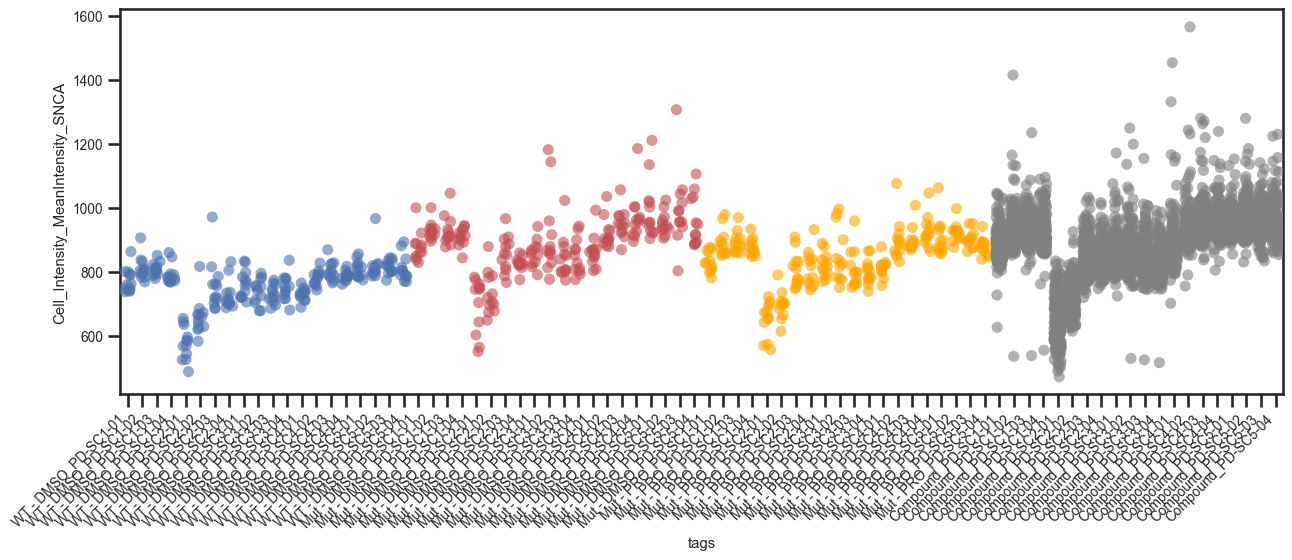

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


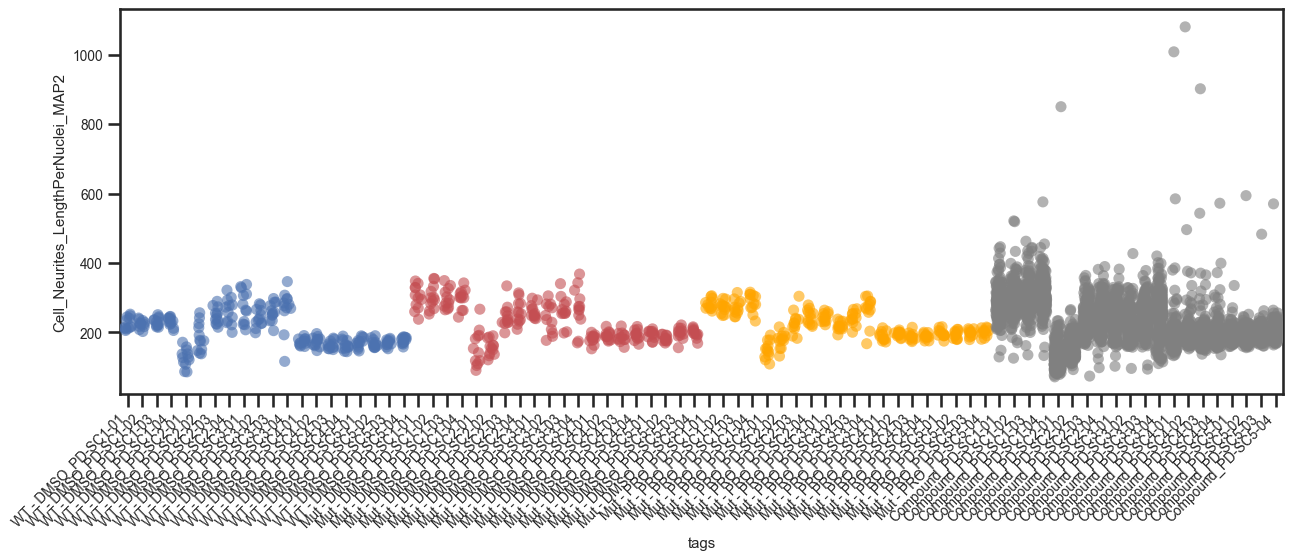

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


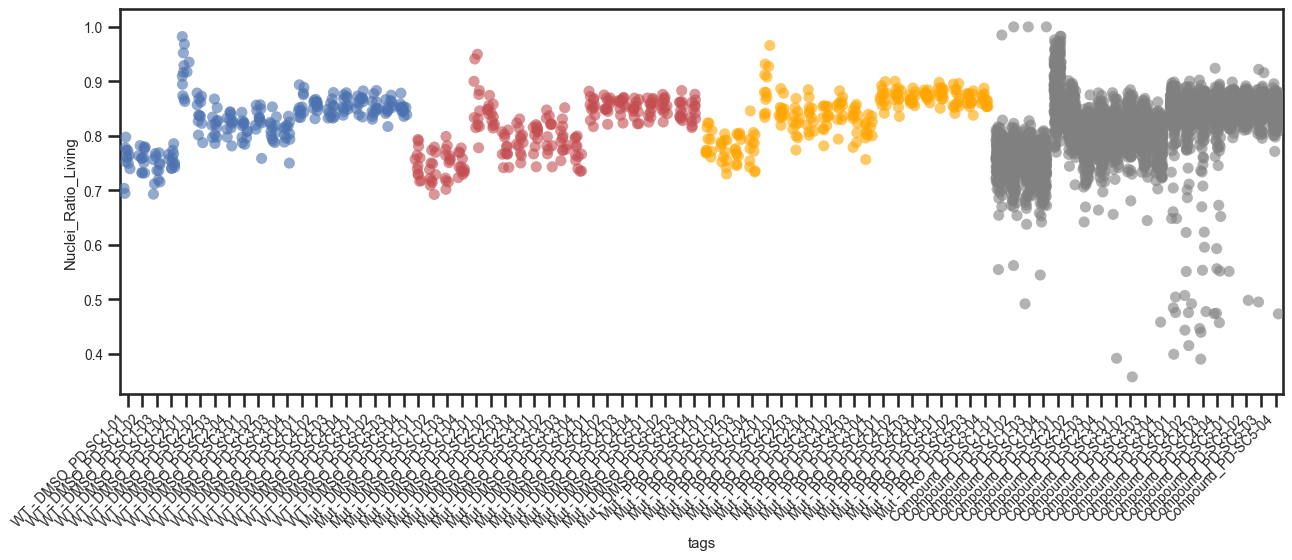

In [10]:
# List of features to draw
list_feature_to_draw = ['Cell_Intensity_MeanIntensity_SNCA',
                        'Cell_Neurites_LengthPerNuclei_MAP2',
                        'Nuclei_Ratio_Living']

# Draw plots for each feature
for feature in list_feature_to_draw:
    with sns.plotting_context("talk", font_scale=0.6), sns.axes_style("ticks"):
        fig, ax = plt.subplots(figsize=(15,5))

        # Overlay stripplot on the boxplot
        p = sns.stripplot(x="tags_plate", y=feature, palette=colors_qc, data=main_df_tot, alpha=0.6,
                            jitter=0.25, size=8, order=order_pl, ax=ax)

        # Set plot aesthetics
        ax.set_xlabel('tags')
        ax.set_ylabel(feature)
        p.legend().remove()
        labels = ax.get_xticklabels()
        ax.set_xticklabels(labels, rotation=45, ha='right')
        plt.savefig(output_path_qc + 'raw_' + feature + '.pdf', bbox_inches='tight')

        plt.show()

### List of used phenotypic features
Absolute features are not used (commented out) and texture features are subjected to feature reduction in a separate step below

In [11]:
### All image features to be used
selected_features = [
            'Cell_Correlation_MAP2_SNCA', 
            'Cell_Correlation_TH_SNCA', 
            'Cell_Correlation_VanSteelselsMeanX_TH_SNCA', 
            'Cell_Correlation_VanSteelselsMeanY_TH_SNCA', 
            'Cell_Correlation_VanSteelselsSigmaX_TH_SNCA', 
            'Cell_Correlation_VanSteelselsSigmaY_TH_SNCA', 
            'Cell_Intensity_MeanIntensity_MAP2', 
            'Cell_Intensity_MeanIntensity_SNCA', 
            'Cell_Intensity_MeanIntensity_TH', 
            'Cell_Intensity_SumIntensityPerNuclei_SNCA', 
            'Cell_MAP2_SNCA_Intensity_MeanIntensity_SNCA', 
            'Cell_Neurites_BranchingPointsPerNuclei_MAP2', 
            'Cell_Neurites_BranchingPointsPerNuclei_TH', 
            'Cell_Neurites_LengthPerNuclei_MAP2', 
            'Cell_Neurites_LengthPerNuclei_TH', 
            # 'Cell_Neurites_Length_MAP2', #
            # 'Cell_Neurites_Length_TH',#
            'Cell_SurfacePerNuclei_MAP2', 
            'Cell_SurfacePerNuclei_MAP2_SNCA', 
            'Cell_SurfacePerNuclei_SNCA', 
            'Cell_SurfacePerNuclei_TH', 
            'Cell_SurfacePerNuclei_TH_SNCA', 
            'Cell_Surface_RatioSurface_TH_SNCA', 
            # 'Cell_Surface_TotalSurface_MAP2', #
            # 'Cell_Surface_TotalSurface_SNCA', #
            # 'Cell_Surface_TotalSurface_SNCA_MAP2',# 
            # 'Cell_Surface_TotalSurface_TH', #
            # 'Cell_Surface_TotalSurface_TH_SNCA',#
            'Cell_TH_SNCA_Intensity_MeanIntensity_SNCA', 
            'Cell_TH_SNCA_Intensity_MeanIntensity_TH', 
            'Cell_TH_SNCA_Intensity_SumIntensityPerNuclei_SNCA', 
            # 'Cell_Texture_SNCA_AngularSecondMoment_000', 
            # 'Cell_Texture_SNCA_AngularSecondMoment_045', 
            # 'Cell_Texture_SNCA_AngularSecondMoment_090', 
            # 'Cell_Texture_SNCA_AngularSecondMoment_135', 
            # 'Cell_Texture_SNCA_Contrast_000', 
            # 'Cell_Texture_SNCA_Contrast_045', 
            # 'Cell_Texture_SNCA_Contrast_090', 
            # 'Cell_Texture_SNCA_Contrast_135', 
            # 'Cell_Texture_SNCA_Correlation_000', 
            # 'Cell_Texture_SNCA_Correlation_045', 
            # 'Cell_Texture_SNCA_Correlation_090', 
            # 'Cell_Texture_SNCA_Correlation_135', 
            # 'Cell_Texture_SNCA_DifferenceEntropy_000', 
            # 'Cell_Texture_SNCA_DifferenceEntropy_045', 
            # 'Cell_Texture_SNCA_DifferenceEntropy_090', 
            # 'Cell_Texture_SNCA_DifferenceEntropy_135', 
            # 'Cell_Texture_SNCA_DifferenceVariance_000', 
            # 'Cell_Texture_SNCA_DifferenceVariance_045', 
            # 'Cell_Texture_SNCA_DifferenceVariance_090', 
            # 'Cell_Texture_SNCA_DifferenceVariance_135', 
            # 'Cell_Texture_SNCA_Entropy_000', 
            # 'Cell_Texture_SNCA_Entropy_045', 
            # 'Cell_Texture_SNCA_Entropy_090', 
            # 'Cell_Texture_SNCA_Entropy_135', 
            # 'Cell_Texture_SNCA_InfoMeasuresOfCorr1_000', 
            # 'Cell_Texture_SNCA_InfoMeasuresOfCorr1_045', 
            # 'Cell_Texture_SNCA_InfoMeasuresOfCorr1_090', 
            # 'Cell_Texture_SNCA_InfoMeasuresOfCorr1_135', 
            # 'Cell_Texture_SNCA_InfoMeasuresOfCorr2_000', 
            # 'Cell_Texture_SNCA_InfoMeasuresOfCorr2_045', 
            # 'Cell_Texture_SNCA_InfoMeasuresOfCorr2_090', 
            # 'Cell_Texture_SNCA_InfoMeasuresOfCorr2_135', 
            # 'Cell_Texture_SNCA_InverseDiffMoment_000', 
            # 'Cell_Texture_SNCA_InverseDiffMoment_045', 
            # 'Cell_Texture_SNCA_InverseDiffMoment_090', 
            # 'Cell_Texture_SNCA_InverseDiffMoment_135', 
            # 'Cell_Texture_SNCA_SumAverage_000', 
            # 'Cell_Texture_SNCA_SumAverage_045', 
            # 'Cell_Texture_SNCA_SumAverage_090', 
            # 'Cell_Texture_SNCA_SumAverage_135', 
            # 'Cell_Texture_SNCA_SumEntropy_000', 
            # 'Cell_Texture_SNCA_SumEntropy_045', 
            # 'Cell_Texture_SNCA_SumEntropy_090', 
            # 'Cell_Texture_SNCA_SumEntropy_135', 
            # 'Cell_Texture_SNCA_SumOfSquares_000', 
            # 'Cell_Texture_SNCA_SumOfSquares_045', 
            # 'Cell_Texture_SNCA_SumOfSquares_090', 
            # 'Cell_Texture_SNCA_SumOfSquares_135', 
            # 'Cell_Texture_SNCA_SumVariance_000', 
            # 'Cell_Texture_SNCA_SumVariance_045', 
            # 'Cell_Texture_SNCA_SumVariance_090', 
            # 'Cell_Texture_SNCA_SumVariance_135', 
            'Cytoplasm_Intensity_MeanIntensity_SNCA', 
            'Cytoplasm_MAP2_SNCA_Intensity_MeanIntensity_SNCA', 
            'Cytoplasm_SurfacePerNuclei_SNCA', 
            'Cytoplasm_SurfacePerNuclei_TH_SNCA', 
            # 'Cytoplasm_Surface_TotalSurface_SNCA', #
            'IndividualCell_Intensity_MeanIntensity_SNCA', 
            'IndividualCell_Intensity_RadialProfile_InterceptFit_SNCA',
            'IndividualCell_Intensity_RadialProfile_MaxSlope_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Maximum_SNCA', 
            #'IndividualCell_Intensity_RadialProfile_MeanCoeffVar_SNCA', 
            'IndividualCell_Intensity_RadialProfile_MeanGradient_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Mean_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Median_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Minimum_SNCA', #
            'IndividualCell_Intensity_RadialProfile_Q1_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Q3_SNCA', 
            'IndividualCell_Intensity_RadialProfile_SlopeFit_SNCA', 
            #'IndividualCell_Intensity_RadialProfile_StdCoeffVar_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Std_SNCA', 
            'IndividualCell_Intensity_SumIntensity_SNCA', 
            'IndividualCell_Surface_MeanSurface_SNCA', 
            # 'Membrane_Intensity_MeanIntensity_MAP2', #### Strange resuts in ctrls (WT).
            'Membrane_Intensity_MeanIntensity_SNCA', 
            'Membrane_Intensity_MeanIntensity_TH', 
            'Membrane_Surface_SurfacePerNuclei_MAP2', 
            'Membrane_Surface_SurfacePerNuclei_SNCA', 
            # 'Membrane_Surface_SurfacePerNuclei_TH', ### Strange resutls in ctrls (WT).
            'Nuclei_Living_Ratio_MAP2', #
            'Nuclei_Living_Ratio_MAP2_SNCA', 
            'Nuclei_Living_Ratio_SNCA', 
            'Nuclei_Living_Ratio_TH_SNCA', 
            # 'Nuclei_Number_Dead',# 
            # 'Nuclei_Number_Living',# 
            # 'Nuclei_Number_MAP2', #
            # 'Nuclei_Number_MAP2_SNCA',# 
            # 'Nuclei_Number_SNCA', #
            # 'Nuclei_Number_TH', #
            # 'Nuclei_Number_TH_SNCA',# 
            'Nuclei_Ratio_Dead', 
            'Nuclei_Ratio_Living', 
            'Nuclei_Surface_MeanArea',
            "tags"]

list_features_textures = ["Cell_Texture_SNCA_AngularSecondMoment_000",
                    "Cell_Texture_SNCA_AngularSecondMoment_045",
                    "Cell_Texture_SNCA_AngularSecondMoment_090",
                    "Cell_Texture_SNCA_AngularSecondMoment_135",
                    "Cell_Texture_SNCA_Contrast_000",
                    "Cell_Texture_SNCA_Contrast_045",
                    "Cell_Texture_SNCA_Contrast_090",
                    "Cell_Texture_SNCA_Contrast_135",
                    "Cell_Texture_SNCA_Correlation_000",
                    "Cell_Texture_SNCA_Correlation_045",
                    "Cell_Texture_SNCA_Correlation_090",
                    "Cell_Texture_SNCA_Correlation_135",
                    "Cell_Texture_SNCA_DifferenceEntropy_000",
                    "Cell_Texture_SNCA_DifferenceEntropy_045",
                    "Cell_Texture_SNCA_DifferenceEntropy_090",
                    "Cell_Texture_SNCA_DifferenceEntropy_135",
                    "Cell_Texture_SNCA_DifferenceVariance_000",
                    "Cell_Texture_SNCA_DifferenceVariance_045",
                    "Cell_Texture_SNCA_DifferenceVariance_090",
                    "Cell_Texture_SNCA_DifferenceVariance_135",
                    "Cell_Texture_SNCA_Entropy_000",
                    "Cell_Texture_SNCA_Entropy_045",
                    "Cell_Texture_SNCA_Entropy_090",
                    "Cell_Texture_SNCA_Entropy_135",
                    "Cell_Texture_SNCA_InfoMeasuresOfCorr1_000",
                    "Cell_Texture_SNCA_InfoMeasuresOfCorr1_045",
                    "Cell_Texture_SNCA_InfoMeasuresOfCorr1_090",
                    "Cell_Texture_SNCA_InfoMeasuresOfCorr1_135",
                    "Cell_Texture_SNCA_InfoMeasuresOfCorr2_000",
                    "Cell_Texture_SNCA_InfoMeasuresOfCorr2_045",
                    "Cell_Texture_SNCA_InfoMeasuresOfCorr2_090",
                    "Cell_Texture_SNCA_InfoMeasuresOfCorr2_135",
                    "Cell_Texture_SNCA_InverseDiffMoment_000",
                    "Cell_Texture_SNCA_InverseDiffMoment_045",
                    "Cell_Texture_SNCA_InverseDiffMoment_090",
                    "Cell_Texture_SNCA_InverseDiffMoment_135",
                    "Cell_Texture_SNCA_SumAverage_000",
                    "Cell_Texture_SNCA_SumAverage_045",
                    "Cell_Texture_SNCA_SumAverage_090",
                    "Cell_Texture_SNCA_SumAverage_135",
                    "Cell_Texture_SNCA_SumEntropy_000",
                    "Cell_Texture_SNCA_SumEntropy_045",
                    "Cell_Texture_SNCA_SumEntropy_090",
                    "Cell_Texture_SNCA_SumEntropy_135",
                    "Cell_Texture_SNCA_SumOfSquares_000",
                    "Cell_Texture_SNCA_SumOfSquares_045",
                    "Cell_Texture_SNCA_SumOfSquares_090",
                    "Cell_Texture_SNCA_SumOfSquares_135",
                    "Cell_Texture_SNCA_SumVariance_000",
                    "Cell_Texture_SNCA_SumVariance_045",
                    "Cell_Texture_SNCA_SumVariance_090",
                    "Cell_Texture_SNCA_SumVariance_135"]
    


### Outlier removal using the Robust StDev method

In [12]:
list_features_for_outliers = [
            'Cell_Intensity_MeanIntensity_MAP2', 
            'Cell_Intensity_MeanIntensity_SNCA', 
            'Cell_Intensity_MeanIntensity_TH',
            'Nuclei_Ratio_Living', 
            'Nuclei_Number_Living',
            'Cell_Neurites_Length_MAP2',
            'tags']

main_df = main_df_tot[selected_features]

main_df_for_outliers = main_df_tot[list_features_for_outliers]

print("Data BEFORE outlier removal:")
display(main_df.tags.value_counts())

main_df_wo_outliers = pd.DataFrame()

main_df_selected_outliers = remove_outliers_by_plate(main_df_for_outliers, outliers_sigma, 'std_robust', ctrl_pos, ctrl_neg, ctrl_pro)

print("Data AFTER outlier removal:")
display(main_df_selected_outliers.tags.value_counts())

Data BEFORE outlier removal:


Compound      4079
WT - DMSO      240
Mut - PRO      240
Mut - DMSO     240
Name: tags, dtype: int64

Data AFTER outlier removal:


Compound      4079
Mut - PRO      234
Mut - DMSO     233
WT - DMSO      231
Name: tags, dtype: int64

### Normalization using the Robust Z-score method 

In [13]:
l_feat = []
avg_z_train = []
avg_z_test = []

main_df_selected_outliers = main_df_selected_outliers.reset_index()
cols = ['Plate', 'Well']
main_df_selected_outliers["Plate_Well"] = main_df_selected_outliers[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
main_df_selected_outliers = main_df_selected_outliers.set_index(['Plate', 'Well'])
main_df = main_df.reset_index()
main_df['Plate_Well'] =  main_df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
main_df_wo_outliers = main_df[main_df.Plate_Well.isin(main_df_selected_outliers.Plate_Well.values)]
main_df_wo_outliers = main_df_wo_outliers.set_index(['Plate', 'Well'])
main_df_wo_outliers = main_df_wo_outliers.drop(['Plate_Well'], axis=1)

main_df = norm_centered_by_plate(main_df_wo_outliers, 'z_robust', ctrl_pos, ctrl_neg, 0, verbose=True)

Cell_Correlation_MAP2_SNCA 0.255659 0.039010247933884315
Cell_Correlation_TH_SNCA 0.25221 0.051000760330578515
Cell_Correlation_VanSteelselsMeanX_TH_SNCA 48.1423 6.570095867768595
Cell_Correlation_VanSteelselsMeanY_TH_SNCA 43.1868 6.2611223140495875
Cell_Correlation_VanSteelselsSigmaX_TH_SNCA 24.2922 7.157388429752064
Cell_Correlation_VanSteelselsSigmaY_TH_SNCA 24.9847 8.281274380165291
Cell_Intensity_MeanIntensity_MAP2 930.477 37.05998347107438
Cell_Intensity_MeanIntensity_SNCA 759.362 30.406380165289235
Cell_Intensity_MeanIntensity_TH 315.874 5.973074380165294
Cell_Intensity_SumIntensityPerNuclei_SNCA 1132080.0 74725.61983471074
Cell_MAP2_SNCA_Intensity_MeanIntensity_SNCA 743.649 32.33545454545456
Cell_Neurites_BranchingPointsPerNuclei_MAP2 2.34498 0.15049685950413216
Cell_Neurites_BranchingPointsPerNuclei_TH 3.82888 0.39109669421487586
Cell_Neurites_LengthPerNuclei_MAP2 215.677 15.126611570247935
Cell_Neurites_LengthPerNuclei_TH 217.767 15.931123966942142
Cell_SurfacePerNuclei_MAP2 

### Plot normalized key feature data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


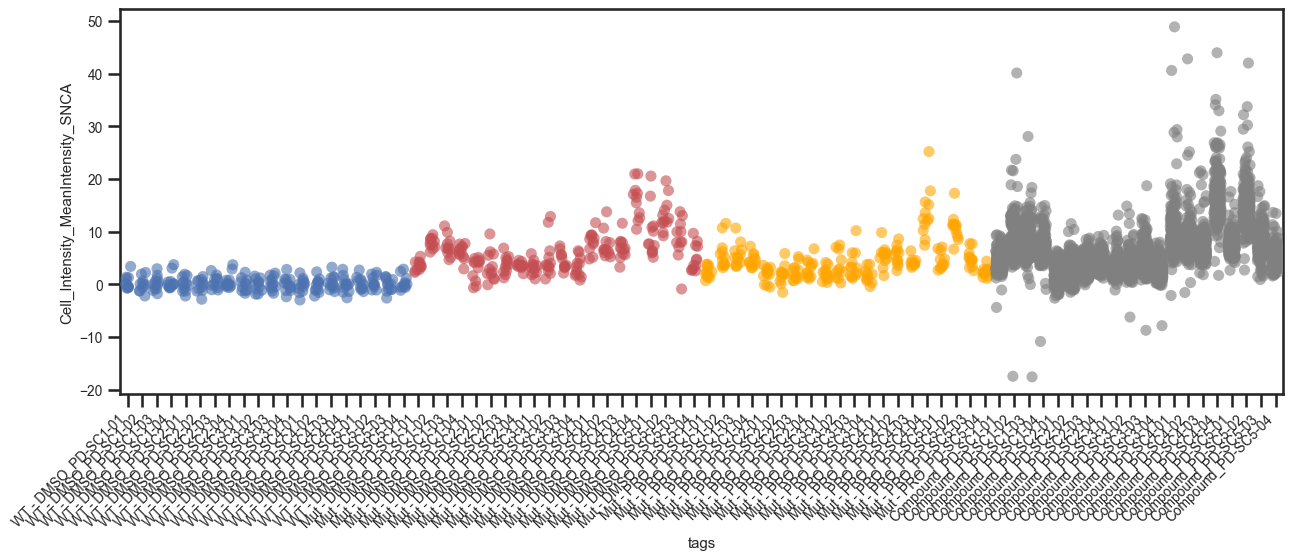

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


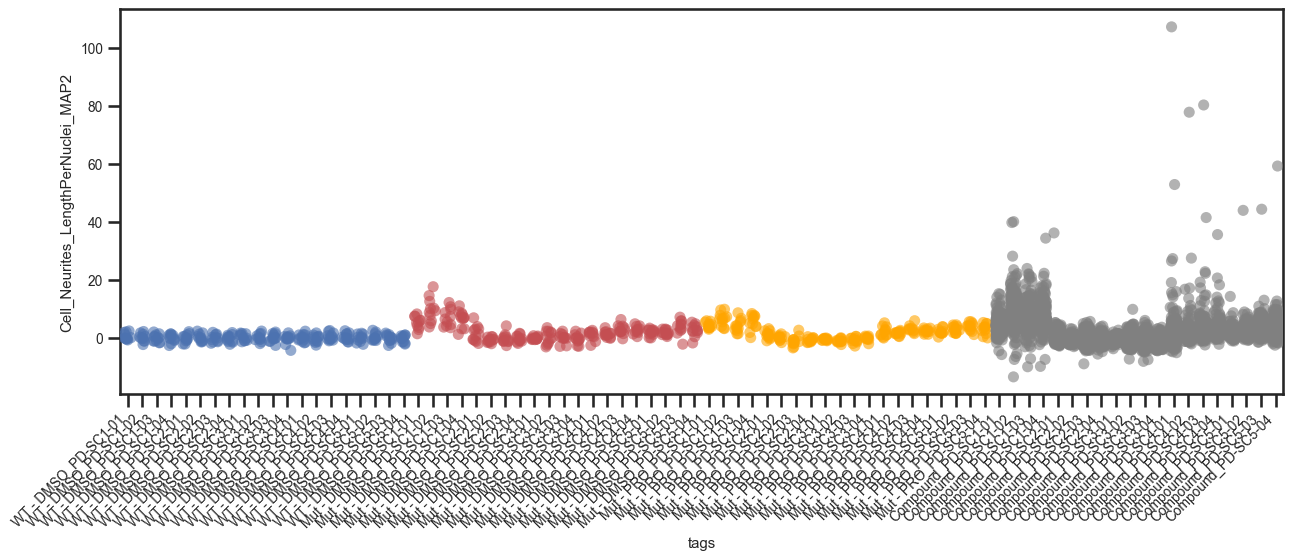

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


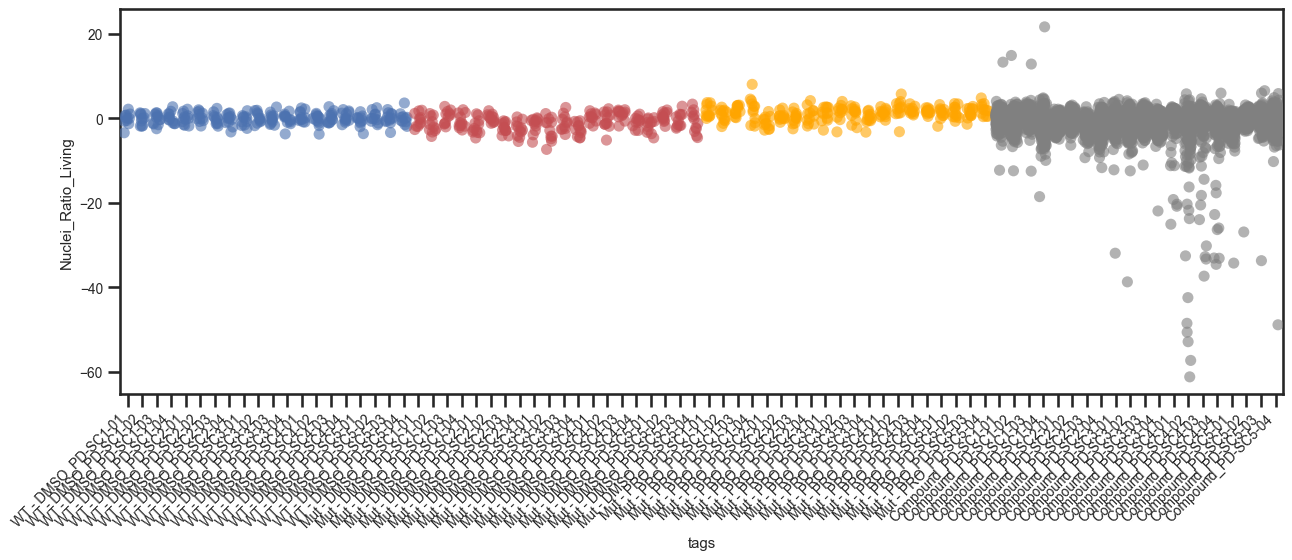

In [14]:
# Add fused tags_plate column to normalized data 
main_df_plate_well = main_df.reset_index()
cols = ['tags', 'Plate']
main_df_plate_well["tags_plate"] = main_df_plate_well[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

# List of features to draw
list_feature_to_draw = ['Cell_Intensity_MeanIntensity_SNCA',
                        'Cell_Neurites_LengthPerNuclei_MAP2',
                        'Nuclei_Ratio_Living']

# Draw plots for each feature
for feature in list_feature_to_draw:
    with sns.plotting_context("talk", font_scale=0.6), sns.axes_style("ticks"):
        fig, ax = plt.subplots(figsize=(15,5))

        # Overlay stripplot on the boxplot
        p = sns.stripplot(x="tags_plate", y=feature, palette=colors_qc, data=main_df_plate_well, alpha=0.6,
                            jitter=0.25, size=8, order=order_pl, ax=ax)

        # Set plot aesthetics
        ax.set_xlabel('tags')
        ax.set_ylabel(feature)
        p.legend().remove()
        labels = ax.get_xticklabels()
        ax.set_xticklabels(labels, rotation=45, ha='right')
        plt.savefig(output_path_qc + 'normalized_' + feature + '.pdf', bbox_inches='tight')

        plt.show()

### Feature selection: Selection of 2 best texture features

In [15]:
# Reset the index of the main_df_selected_outliers dataframe
main_df_selected_outliers = main_df_selected_outliers.reset_index()

# Define the columns to be used for creating the Plate_Well column
cols = ['Plate', 'Well']

# Create a new column Plate_Well in the main_df_selected_outliers dataframe by concatenating the values in the Plate and Well columns with an underscore
main_df_selected_outliers["Plate_Well"] = main_df_selected_outliers[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

# Set the index of the main_df_selected_outliers dataframe to be a MultiIndex of Plate and Well
main_df_selected_outliers = main_df_selected_outliers.set_index(['Plate', 'Well'])

# Reset the index of the main_df dataframe
main_df = main_df.reset_index()

# Create a new column Plate_Well in the main_df dataframe by concatenating the values in the Plate and Well columns with an underscore
main_df['Plate_Well'] =  main_df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

# Remove outliers from main_df by only keeping rows where Plate_Well is also present in main_df_selected_outliers
main_df_wo_outliers = main_df[main_df.Plate_Well.isin(main_df_selected_outliers.Plate_Well.values)]

# Set the index of the main_df_wo_outliers dataframe to be a MultiIndex of Plate and Well
main_df_wo_outliers = main_df_wo_outliers.set_index(['Plate', 'Well'])

# Drop the Plate_Well column from the main_df_wo_outliers dataframe
main_df_wo_outliers = main_df_wo_outliers.drop(['Plate_Well'], axis=1)

# Calculate the z-factors for each feature in list_features_textures using the get_z_added_feature function
zfactors_per_feature = [get_z_added_feature(main_df_wo_outliers, main_df_tot, feature_texture, ctrl_neg, ctrl_pos, method='z_score_robust') for feature_texture in list_features_textures]

# Unpack the results into three lists: list_features_texture, list_avg_ztrain, and list_avg_ztest
list_features_texture, list_avg_ztrain, list_avg_ztest = zip(*zfactors_per_feature)

# Create a new dataframe df_best_texture_feature with the features and their corresponding z-factors
df_best_texture_feature = pd.DataFrame()
df_best_texture_feature['Feature'] = list_features_texture #l_feat
df_best_texture_feature['Z_Train'] = list_avg_ztrain # avg_z_train
df_best_texture_feature['Z_Test'] = list_avg_ztest # avg_z_test

# Sort df_best_texture_feature by the z-factor for the test set in descending order
df_best_texture_feature = df_best_texture_feature.sort_values(['Z_Test'], ascending=False)

# Select the top two features
first_best_texture_feature = df_best_texture_feature.Feature.values[0]
second_best_texture_feature = df_best_texture_feature.Feature.values[1]

# Print out the top two features
print('First Best Texture Feature : ', first_best_texture_feature)
print('Second Best Texture Feature : ', second_best_texture_feature)

# Add these top two features to the beginning of the main_df_wo_outliers dataframe and selected_features list
main_df_wo_outliers.insert(0, first_best_texture_feature, main_df_tot[first_best_texture_feature])
main_df_wo_outliers.insert(0, second_best_texture_feature, main_df_tot[second_best_texture_feature])

selected_features.insert(0, first_best_texture_feature)
selected_features.insert(0, second_best_texture_feature)

# Normalize the main_df_wo_outliers dataframe using norm_centered_by_plate function
main_df = norm_centered_by_plate(main_df_wo_outliers, 'z_robust', ctrl_pos, ctrl_neg, 0, verbose=True)


First Best Texture Feature :  Cell_Texture_SNCA_AngularSecondMoment_000
Second Best Texture Feature :  Cell_Texture_SNCA_AngularSecondMoment_045
Cell_Texture_SNCA_AngularSecondMoment_045 0.00339096 0.0005598451239669423
Cell_Texture_SNCA_AngularSecondMoment_000 0.00371164 0.000597587603305785
Cell_Correlation_MAP2_SNCA 0.0 0.9999999999999997
Cell_Correlation_TH_SNCA 0.0 1.0
Cell_Correlation_VanSteelselsMeanX_TH_SNCA 0.0 0.9999999999999999
Cell_Correlation_VanSteelselsMeanY_TH_SNCA 0.0 1.0
Cell_Correlation_VanSteelselsSigmaX_TH_SNCA 0.0 1.0
Cell_Correlation_VanSteelselsSigmaY_TH_SNCA 0.0 0.9999999999999997
Cell_Intensity_MeanIntensity_MAP2 0.0 1.0
Cell_Intensity_MeanIntensity_SNCA 0.0 1.0000000000000009
Cell_Intensity_MeanIntensity_TH 0.0 0.9999999999999997
Cell_Intensity_SumIntensityPerNuclei_SNCA 0.0 1.0000000000000002
Cell_MAP2_SNCA_Intensity_MeanIntensity_SNCA 0.0 0.9999999999999999
Cell_Neurites_BranchingPointsPerNuclei_MAP2 0.0 1.0000000000000002
Cell_Neurites_BranchingPointsPerNu

### Select data for classification (features and plates) 

In [16]:
# All data
X_all_cpds = main_df[selected_features[:-1]]
Y_all_cpds = main_df['tags']

# For 3-class LDA
df_3cl = main_df[main_df.tags.isin([ctrl_neg, ctrl_pos, ctrl_pro])]
df_3cl_plate_selected = df_3cl.reset_index()
# Remove unwanted plates
df_3cl_plate_selected_wo_plates = df_3cl_plate_selected[~(df_3cl_plate_selected.Plate.isin(list_plates_to_remove))]
df_3cl_plate_selected = df_3cl_plate_selected_wo_plates.set_index(['Plate','Well'])
# Use selected features only
X_3cl = df_3cl_plate_selected[selected_features[:-1]]
Y_3cl = df_3cl_plate_selected['tags']

### Additional feature selection
Choose only one feature out of the features grouped by correlation

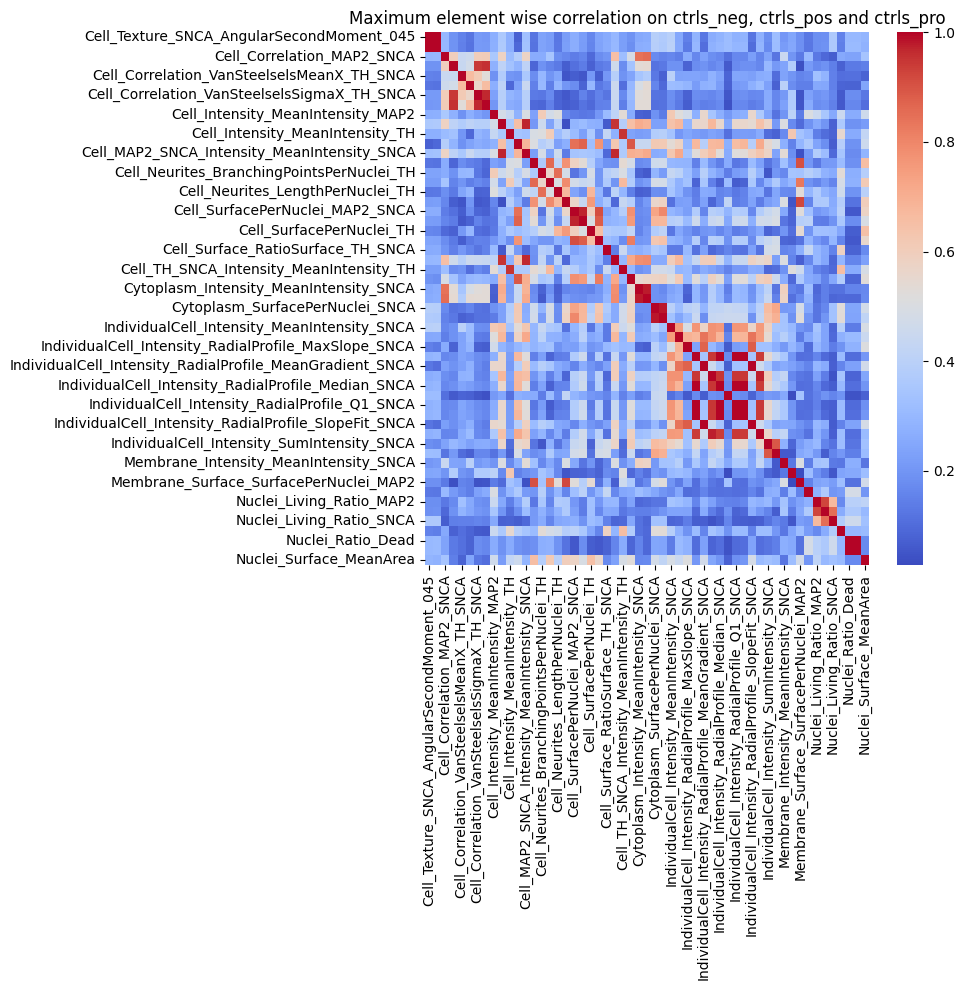

features and their number of occurance in different sub groups:


feature  \
0         Cell_Correlation_VanSteelselsSigmaY_TH_SNCA   
1    IndividualCell_Intensity_RadialProfile_Mean_SNCA   
2      IndividualCell_Intensity_RadialProfile_Q1_SNCA   
3                             Nuclei_Surface_MeanArea   
4                    Cell_Neurites_LengthPerNuclei_TH   
5   Cell_TH_SNCA_Intensity_SumIntensityPerNuclei_SNCA   
6             Cell_TH_SNCA_Intensity_MeanIntensity_TH   
7           Cell_TH_SNCA_Intensity_MeanIntensity_SNCA   
8                   Cell_Surface_RatioSurface_TH_SNCA   
9                       Cell_SurfacePerNuclei_TH_SNCA   
10                           Cell_SurfacePerNuclei_TH   
11                         Cell_SurfacePerNuclei_SNCA   
12                    Cell_SurfacePerNuclei_MAP2_SNCA   
13                         Cell_SurfacePerNuclei_MAP2   
14                 Cell_Neurites_LengthPerNuclei_MAP2   
15          Cell_Texture_SNCA_AngularSecondMoment_045   
16          Cell_Neurites_BranchingPointsPerNuclei_TH   
17        Cell_Neurites_BranchingPointsPerNuclei_MAP2   
18        Cell_MAP2_SNCA_Intensity_MeanIntensity_SNCA   
19          Cell_Intensity_SumIntensityPerNuclei_SNCA   
20                    Cell_Intensity_MeanIntensity_TH   
21                  Cell_Intensity_MeanIntensity_SNCA   
22                  Cell_Intensity_MeanIntensity_MAP2   
23        Cell_Correlation_VanSteelselsSigmaX_TH_SNCA   
24         Cell_Correlation_VanSteelselsMeanY_TH_SNCA   
25         Cell_Correlation_VanSteelselsMeanX_TH_SNCA   
26                           Cell_Correlation_TH_SNCA   
27          Cell_Texture_SNCA_AngularSecondMoment_000   
28   Cytoplasm_MAP2_SNCA_Intensity_MeanIntensity_SNCA   
29             Cytoplasm_Intensity_MeanIntensity_SNCA   
30                                Nuclei_Ratio_Living   
31                                  Nuclei_Ratio_Dead   
32                        Nuclei_Living_Ratio_TH_SNCA   
33                           Nuclei_Living_Ratio_SNCA   
34                      Nuclei_Living_Ratio_MAP2_SNCA   
35                           Nuclei_Living_Ratio_MAP2   
36             Membrane_Surface_SurfacePerNuclei_SNCA   
37             Membrane_Surface_SurfacePerNuclei_MAP2   
38                Membrane_Intensity_MeanIntensity_TH   
39              Membrane_Intensity_MeanIntensity_SNCA   
40            IndividualCell_Surface_MeanSurface_SNCA   
41         IndividualCell_Intensity_SumIntensity_SNCA   
42    IndividualCell_Intensity_RadialProfile_Std_SNCA   
43  IndividualCell_Intensity_RadialProfile_SlopeFi...   
44     IndividualCell_Intensity_RadialProfile_Q3_SNCA   
45  IndividualCell_Intensity_RadialProfile_Minimum...   
46  IndividualCell_Intensity_RadialProfile_Median_...   
47  IndividualCell_Intensity_RadialProfile_MeanGra...   
48  IndividualCell_Intensity_RadialProfile_Maximum...   
49  IndividualCell_Intensity_RadialProfile_MaxSlop...   
50  IndividualCell_Intensity_RadialProfile_Interce...   
51        IndividualCell_Intensity_MeanIntensity_SNCA   
52                 Cytoplasm_SurfacePerNuclei_TH_SNCA   
53                    Cytoplasm_SurfacePerNuclei_SNCA   
54                         Cell_Correlation_MAP2_SNCA   

    occurance in different subgroups  \
0                                  2   
1                                  2   
2                                  2   
3                                  1   
4                                  1   
5                                  1   
6                                  1   
7                                  1   
8                                  1   
9                                  1   
10                                 1   
11                                 1   
12                                 1   
13                                 1   
14                                 1   
15                                 1   
16                                 1   
17                                 1   
18                                 1   
19                                 1   
20           

In [17]:
# Correlation threshold
thr_corr = 0.95

X_corr_pos = X_3cl[Y_3cl=='WT - DMSO']
X_corr_neg = X_3cl[Y_3cl=='Mut - DMSO']
X_corr_pro = X_3cl[Y_3cl=='Mut - PRO']

correlations_pos = X_corr_pos.corr().abs()
correlations_neg = X_corr_neg.corr().abs()
correlations_pro = X_corr_pro.corr().abs()

corr = np.fmax(correlations_pos, correlations_neg)
corr = np.fmax(corr, correlations_pro)

f, ax = plt.subplots(figsize=(10, 10))
h = sns.heatmap(corr, cmap='coolwarm', ax=ax)
ax.set_title('Maximum element wise correlation on ctrls_neg, ctrls_pos and ctrls_pro')
plt.tight_layout()
plt.show()

mask_keep = np.triu(np.ones(corr.shape), k=0).astype('bool').reshape(corr.size)
sr = corr.stack()[mask_keep]
edges = sr[sr > thr_corr].reset_index().values[:, :2]
graph_correlated_features = nx.from_edgelist(edges)
ls_cliques = []
for clique in nx.algorithms.find_cliques(graph_correlated_features):
    ls_cliques.append(clique)
    
features_occurance= []
for l in ls_cliques:
    features_occurance = features_occurance + l
temp = np.unique(features_occurance, return_counts = True)
ind_sort = temp[1].argsort()[::-1]
temp = (temp[0][ind_sort],temp[1][ind_sort])
df_feature_occurance = pd.DataFrame(columns = ["feature","occurance in different subgroups"])
df_feature_occurance["feature"] = temp[0]
df_feature_occurance["occurance in different subgroups"] = temp[1]
# find all the feature groups that one feature appears in
for feature in df_feature_occurance.feature:
    df_feature_occurance.loc[df_feature_occurance.feature == feature, 'list of subgroups'] = ";".join([str(l) for l in ls_cliques if feature in l])
print("features and their number of occurance in different sub groups:")
display(df_feature_occurance)
fig = plot_graph_correlation_relations(graph_correlated_features,corr, title = "graph of all correlation relations between features")
fig.show()
## graph for all the complete subgraphs
temp_graph = graph_correlated_features.copy()
graphs = []
while True:
    cleque_max = clq.max_clique(temp_graph)
    temp_graph.remove_nodes_from(list(cleque_max))
    graphs.append(nx.complete_graph(cleque_max))
    if len(list(temp_graph.nodes)) == 0:
        break

all_subgraphs_compelets_features = nx.compose_all(graphs)
fig = plot_graph_correlation_relations(all_subgraphs_compelets_features, corr, title = "graph of all independent complete correlation relations between features")
fig.show()

Overview of all isolated features (features not correlation with another one) and all clustered features (two or more correlated features)

In [18]:
def fetch_connected_nodes(G, node, seen = None):
    if seen == None:
        seen = set([node])
    for neighbor in G.neighbors(node):
        # print(neighbor)
        if neighbor not in seen:
            seen.add(neighbor)
            fetch_connected_nodes(G, neighbor, seen)
    return seen

# display(X_3cl.columns)
print(len(all_subgraphs_compelets_features))
print("Isolated Features :")
display(list(nx.isolates(all_subgraphs_compelets_features)))

l_nodes = []
for n in all_subgraphs_compelets_features.nodes:
    l_nodes.append(fetch_connected_nodes(all_subgraphs_compelets_features, n))

clust = set()
for i in l_nodes:
    clust.add(tuple(sorted(i)))

list_auto_chosen = []

for cl in clust:
    print("Clustered Features :")
    print(cl)
    list_auto_chosen.append(cl[0])

list_auto_chosen = np.unique(list_auto_chosen)
list_auto_chosen = list(list_auto_chosen)

55
Isolated Features :


['Nuclei_Surface_MeanArea',
 'Nuclei_Living_Ratio_TH_SNCA',
 'Nuclei_Living_Ratio_SNCA',
 'Nuclei_Living_Ratio_MAP2_SNCA',
 'Nuclei_Living_Ratio_MAP2',
 'Membrane_Surface_SurfacePerNuclei_SNCA',
 'Membrane_Surface_SurfacePerNuclei_MAP2',
 'Membrane_Intensity_MeanIntensity_TH',
 'Membrane_Intensity_MeanIntensity_SNCA',
 'IndividualCell_Surface_MeanSurface_SNCA',
 'IndividualCell_Intensity_SumIntensity_SNCA',
 'IndividualCell_Intensity_RadialProfile_Minimum_SNCA',
 'IndividualCell_Intensity_RadialProfile_MaxSlope_SNCA',
 'IndividualCell_Intensity_RadialProfile_InterceptFit_SNCA',
 'IndividualCell_Intensity_MeanIntensity_SNCA',
 'Cell_TH_SNCA_Intensity_SumIntensityPerNuclei_SNCA',
 'Cell_Surface_RatioSurface_TH_SNCA',
 'Cell_SurfacePerNuclei_TH_SNCA',
 'Cell_SurfacePerNuclei_TH',
 'Cell_SurfacePerNuclei_MAP2',
 'Cell_Neurites_LengthPerNuclei_TH',
 'Cell_Neurites_LengthPerNuclei_MAP2',
 'Cell_Neurites_BranchingPointsPerNuclei_TH',
 'Cell_Neurites_BranchingPointsPerNuclei_MAP2',
 'Cell_Inte

Clustered Features :
('Cell_Correlation_VanSteelselsMeanY_TH_SNCA',)
Clustered Features :
('Cell_Correlation_VanSteelselsSigmaX_TH_SNCA',)
Clustered Features :
('Nuclei_Ratio_Dead', 'Nuclei_Ratio_Living')
Clustered Features :
('Nuclei_Surface_MeanArea',)
Clustered Features :
('Nuclei_Living_Ratio_TH_SNCA',)
Clustered Features :
('Cell_Correlation_MAP2_SNCA',)
Clustered Features :
('Nuclei_Living_Ratio_MAP2_SNCA',)
Clustered Features :
('Cell_Intensity_MeanIntensity_MAP2',)
Clustered Features :
('IndividualCell_Intensity_RadialProfile_MaxSlope_SNCA',)
Clustered Features :
('Membrane_Surface_SurfacePerNuclei_SNCA',)
Clustered Features :
('IndividualCell_Intensity_RadialProfile_Mean_SNCA', 'IndividualCell_Intensity_RadialProfile_Std_SNCA')
Clustered Features :
('Nuclei_Living_Ratio_MAP2',)
Clustered Features :
('Cell_Intensity_SumIntensityPerNuclei_SNCA',)
Clustered Features :
('Cell_Neurites_BranchingPointsPerNuclei_TH',)
Clustered Features :
('IndividualCell_Intensity_RadialProfile_Mean

Out of each correlation cluster one feature is chosen & and all uncorrelated features are chosen as well

In [19]:
chosen_features_biologists = ['IndividualCell_Intensity_RadialProfile_Mean_SNCA',
                            'Cell_Texture_SNCA_AngularSecondMoment_000',
                            'IndividualCell_Intensity_RadialProfile_Median_SNCA',
                            'Nuclei_Ratio_Living',
                            'IndividualCell_Intensity_RadialProfile_SlopeFit_SNCA',
                            'Cell_Correlation_TH_SNCA',
                            'Cytoplasm_SurfacePerNuclei_SNCA',
                            'Cell_Intensity_MeanIntensity_SNCA',
                            'Cell_SurfacePerNuclei_SNCA',
                            'Cytoplasm_Intensity_MeanIntensity_SNCA']

after_correlation_features = list(nx.isolates(all_subgraphs_compelets_features)) + chosen_features_biologists
assert len(chosen_features_biologists) != 0, "chosen_features_biologists should not be empty \n please choose a feature from high correlated features"
print(len(chosen_features_biologists), len(list(nx.isolates(all_subgraphs_compelets_features))), len(after_correlation_features), len(set(after_correlation_features)))
subset_columns = after_correlation_features

# Now, when you print the list, all elements should be displayed
print(subset_columns)

10 30 40 40
['Nuclei_Surface_MeanArea', 'Nuclei_Living_Ratio_TH_SNCA', 'Nuclei_Living_Ratio_SNCA', 'Nuclei_Living_Ratio_MAP2_SNCA', 'Nuclei_Living_Ratio_MAP2', 'Membrane_Surface_SurfacePerNuclei_SNCA', 'Membrane_Surface_SurfacePerNuclei_MAP2', 'Membrane_Intensity_MeanIntensity_TH', 'Membrane_Intensity_MeanIntensity_SNCA', 'IndividualCell_Surface_MeanSurface_SNCA', 'IndividualCell_Intensity_SumIntensity_SNCA', 'IndividualCell_Intensity_RadialProfile_Minimum_SNCA', 'IndividualCell_Intensity_RadialProfile_MaxSlope_SNCA', 'IndividualCell_Intensity_RadialProfile_InterceptFit_SNCA', 'IndividualCell_Intensity_MeanIntensity_SNCA', 'Cell_TH_SNCA_Intensity_SumIntensityPerNuclei_SNCA', 'Cell_Surface_RatioSurface_TH_SNCA', 'Cell_SurfacePerNuclei_TH_SNCA', 'Cell_SurfacePerNuclei_TH', 'Cell_SurfacePerNuclei_MAP2', 'Cell_Neurites_LengthPerNuclei_TH', 'Cell_Neurites_LengthPerNuclei_MAP2', 'Cell_Neurites_BranchingPointsPerNuclei_TH', 'Cell_Neurites_BranchingPointsPerNuclei_MAP2', 'Cell_Intensity_SumInt

### Final data frame for classification after outlier removal, normalization and feature reduction

In [20]:
# Save normalized dataframe without outliers
df_3cl_plate_selected[subset_columns + ['tags']].to_csv(output_path_csv+'before_classification_processed_data.csv')

### 3-class LDA classification

Linear Discriminant Analysis (LDA) is used to find a linear combination of features that characterizes or separates two or more classes. In the case of a 3-class LDA classification, the method is used to separate three different classes of objects or events (here: Mut cells, Ctrl cells, and Mut cells treated with compounds).

Model training is only performed on the three control classes Mut-PRO, Mut-DMSO, WT-DMSO. 

Mut - PRO     210
Mut - DMSO    209
WT - DMSO     208
Name: tags, dtype: int64
Cross valid Accuracy : [0.95238095 0.98412698 0.95238095 0.95238095 0.96825397 0.84126984
 0.87301587 0.9516129  0.96774194 0.90322581]
Cross valid : 0.93 (+/- 0.04)


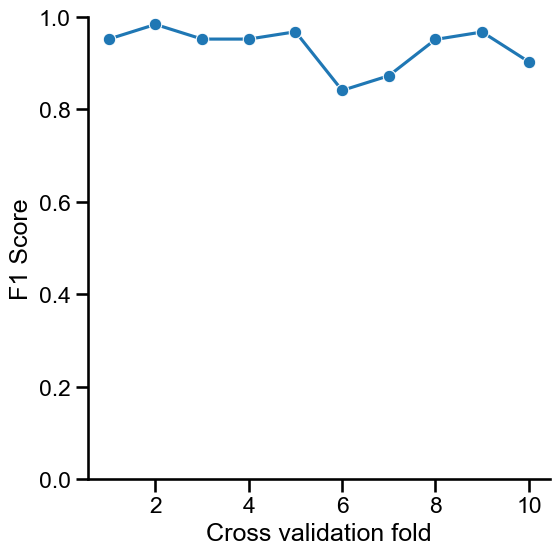

              precision    recall  f1-score   support

  Mut - DMSO       0.95      0.93      0.94        42
   Mut - PRO       0.93      0.95      0.94        42
   WT - DMSO       1.00      1.00      1.00        42

    accuracy                           0.96       126
   macro avg       0.96      0.96      0.96       126
weighted avg       0.96      0.96      0.96       126

F1 micro: 0.9603
F1 macro: 0.9603
F1 weighted: 0.9603
Accuracy: 0.9603


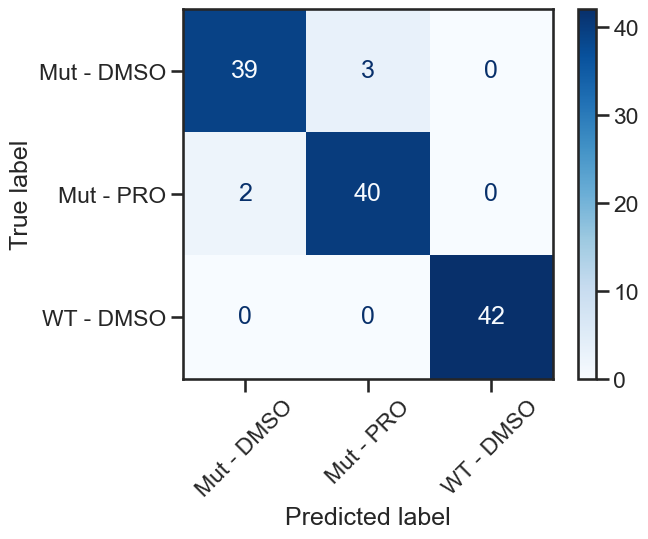

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set the seaborn style to "talk" and font to "Arial"
sns.set_context("talk")
rcParams['font.family'] = 'Arial'

# Create the output directory if it does not exist
if not os.path.exists(output_path):
	os.makedirs(output_path, exist_ok=True)

# Set the proportion of data to be used for training
train_set_proportion = 0.8
# Set the shrinkage parameter for the LDA analysis
shrink = 'auto'

# Create a label encoder object
le_3cl = LabelEncoder()
# Print the value counts of the target variable
print(Y_3cl.value_counts())

# Split the data into training and testing sets
x_train_3cl, x_test_3cl, y_train_3cl, y_test_3cl = train_test_split(X_3cl[subset_columns], Y_3cl, train_size=train_set_proportion, stratify=Y_3cl, random_state=100)

# Create an LDA object and fit it to the training data
lda_analysis_3cl = LDA(solver='eigen', n_components=2, shrinkage=shrink)
lda_analysis_3cl.fit(x_train_3cl, y_train_3cl)

# Perform 10-fold cross validation on the entire dataset and print the results
# f1_micro stands for the micro-averaged F1 score, which is a measure of a model’s accuracy that considers both precision and recall and gives equal weight to each individual example across all classes
scores_3cl = cross_val_score(lda_analysis_3cl, X_3cl, Y_3cl, cv=10, scoring='f1_micro')
print("Cross valid Accuracy :", scores_3cl)
print("Cross valid : %0.2f (+/- %0.2f)" % (scores_3cl.mean(), scores_3cl.std()))

# Plot the cross validation scores
plt.figure(figsize=(6,6)) # Set the figure size to make it square
ax = sns.lineplot(range(1, 11), scores_3cl, marker='o')
ax.set(xlabel='Cross validation fold', ylabel='F1 Score')
ax.set_box_aspect(1)
plt.ylim([0,1]) # Set y-axis scale from 0 to 1
sns.despine()
plt.savefig(output_path + '10-Fold-Cross-Validation-Scores' + '.pdf', bbox_inches='tight')
plt.show()


# Make predictions on the test data
pred_test_3cl = lda_analysis_3cl.predict(x_test_3cl)
# Transform the training and test data using the fitted LDA object
LDA_train_3cl = lda_analysis_3cl.transform(x_train_3cl)
LDA_test_3cl = lda_analysis_3cl.transform(x_test_3cl)

# Print a classification report for the test data
print(metrics.classification_report(y_test_3cl, pred_test_3cl))

# Print various F1 scores and accuracy for the test data
print("F1 micro: %1.4f" % f1_score(y_test_3cl, pred_test_3cl, average='micro'))
print("F1 macro: %1.4f" % f1_score(y_test_3cl, pred_test_3cl, average='macro'))
print("F1 weighted: %1.4f" % f1_score(y_test_3cl, pred_test_3cl, average='weighted'))
print("Accuracy: %1.4f" % (accuracy_score(y_test_3cl, pred_test_3cl)))

# Create a confusion matrix for the test data and display it
cm = confusion_matrix(y_test_3cl, pred_test_3cl, labels=lda_analysis_3cl.classes_)
sns.set_style("ticks")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lda_analysis_3cl.classes_)
disp.plot(cmap='Blues')
plt.xticks(rotation=45)
# Save plot
plt.savefig(output_path + '3-Class-LDA_ConfusionMatrix' + '.pdf', bbox_inches='tight')
plt.show()

# Create an empty DataFrame to store training set information
df_training_set_3cl = pd.DataFrame()


### Plot the 3-class LDA transformed data without and with compounds

In the previous step, a 3-class LDA classifier was trained using only the three control classes Mut-PRO, Mut-DMSO, WT-DMSO. 

1) In a first step, the two first two Linear Discriminants (LDs) calculated by the LDA algorithm are plotted for these control classes.

2) In a second step, the pre-trained 3-class LDA classifier named lda_analysis_3cl is used to transform the compound-related data.

3) In a third step, all three control classes and the compound-data is shown in the same plot.

The two different axis labels, LDA_0 and LDA_1, represent the first two LDs calculated by the LDA algorithm. These LDs are linear combinations of the input features that maximize the separation between the classes. The first axis (LDA_0) accounts for the maximum variation among the classes, while the second axis (LDA_1) accounts for the second highest variation.

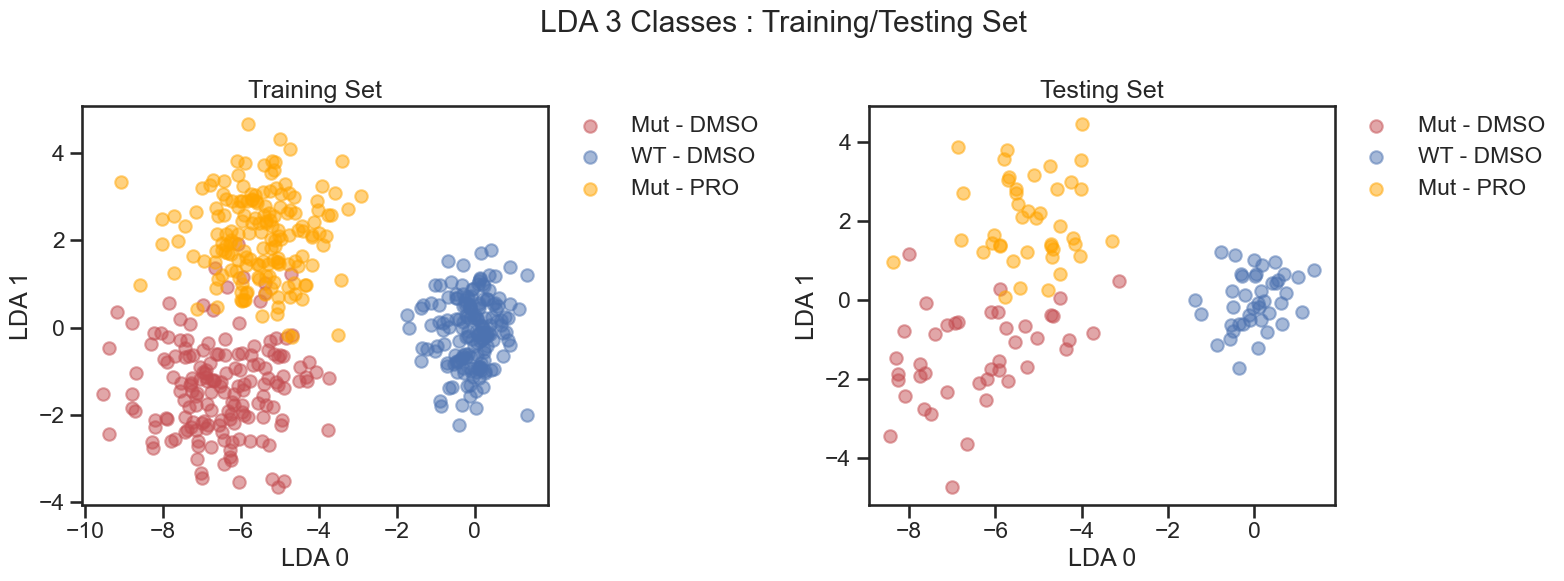

['WT - DMSO', 'Mut - DMSO', 'Mut - PRO', 'Compound']


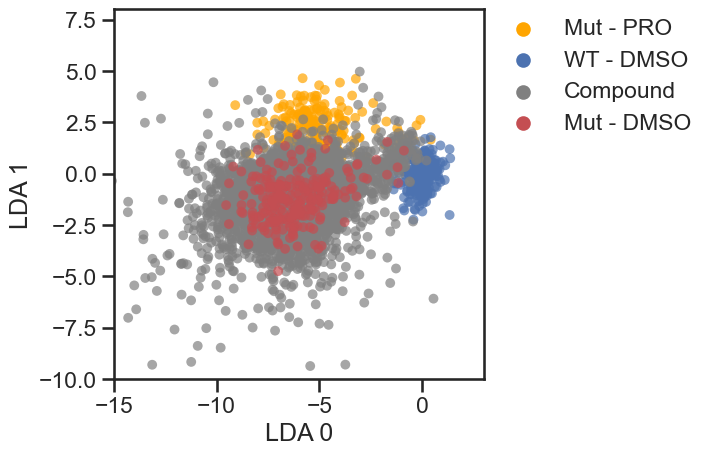

In [22]:
# Plot the transformed training and test data
with sns.axes_style("white"), sns.axes_style("ticks"), sns.plotting_context("talk"):
    # Create a figure with two subplots
    fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
    # Plot the transformed training data for each class on the first subplot
    axes[0].scatter(LDA_train_3cl[:,0][y_train_3cl==ctrl_neg], LDA_train_3cl[:,1][y_train_3cl==ctrl_neg], c=dict_color[ctrl_neg], label=ctrl_neg, alpha=0.5)
    axes[0].scatter(LDA_train_3cl[:,0][y_train_3cl==ctrl_pos], LDA_train_3cl[:,1][y_train_3cl==ctrl_pos], c=dict_color[ctrl_pos], label=ctrl_pos, alpha=0.5)
    axes[0].scatter(LDA_train_3cl[:,0][y_train_3cl==ctrl_pro], LDA_train_3cl[:,1][y_train_3cl==ctrl_pro], c=dict_color[ctrl_pro], label=ctrl_pro, alpha=0.5)
    # Set the x and y labels and title for the first subplot
    axes[0].set_xlabel('LDA 0')
    axes[0].set_ylabel('LDA 1')
    axes[0].set_title('Training Set')

    # Plot the transformed test data for each class on the second subplot
    axes[1].scatter(LDA_test_3cl[:,0][y_test_3cl==ctrl_neg], LDA_test_3cl[:,1][y_test_3cl==ctrl_neg], c=dict_color[ctrl_neg], label=ctrl_neg, alpha=0.5)
    axes[1].scatter(LDA_test_3cl[:,0][y_test_3cl==ctrl_pos], LDA_test_3cl[:,1][y_test_3cl==ctrl_pos], c=dict_color[ctrl_pos], label=ctrl_pos, alpha=0.5)
    axes[1].scatter(LDA_test_3cl[:,0][y_test_3cl==ctrl_pro], LDA_test_3cl[:,1][y_test_3cl==ctrl_pro], c=dict_color[ctrl_pro], label=ctrl_pro, alpha=0.5)
    # Set the x and y labels and title for the second subplot
    axes[1].set_xlabel('LDA 0')
    axes[1].set_ylabel('LDA 1')
    axes[1].set_title('Testing Set')

    # Add legends to both subplots
    axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
    axes[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)

    # Set the overall title for the figure
    plt.suptitle("LDA 3 Classes : Training/Testing Set")
    # Adjust the layout of the figure
    plt.tight_layout()
    
    # Save plot
    plt.savefig(output_path + '3-Class-LDA_NoCompounds_ControlsOnly' + '.pdf', bbox_inches='tight')

    # Show the figure
    plt.show()


# Same plot, but now with projected compound data

# Define a function to calculate the median absolute deviation (MAD) of an array
def mad(arr, axis=None, keepdims=True):
    # Calculate the median of the array along the specified axis
    median = np.median(arr, axis=axis, keepdims=True)
    # Calculate the MAD by taking the median of the absolute deviations from the median
    mad = np.median(np.abs(arr-median),axis=axis, keepdims=keepdims)
    return mad

# Reset the index of the negative control samples in the training data
y_pl_well_neg = y_train_3cl[y_train_3cl==ctrl_neg]
y_pl_well_neg = y_pl_well_neg.reset_index()

# Reset the index of the positive control samples in the training data
y_pl_well_pos = y_train_3cl[y_train_3cl==ctrl_pos]
y_pl_well_pos = y_pl_well_pos.reset_index()

# Reset the index of the Prostratin control samples in the training data
y_pl_well_pro = y_train_3cl[y_train_3cl==ctrl_pro]
y_pl_well_pro = y_pl_well_pro.reset_index()

# Create a DataFrame for negative control samples and add LDA columns
df_neg = pd.DataFrame()
df_neg['LDA_0'] = LDA_train_3cl[:,0][y_train_3cl==ctrl_neg]
df_neg['LDA_1'] = LDA_train_3cl[:,1][y_train_3cl==ctrl_neg]

# Create a DataFrame for positive control samples and add LDA columns
df_pos = pd.DataFrame()
df_pos['LDA_0'] = LDA_train_3cl[:,0][y_train_3cl==ctrl_pos]
df_pos['LDA_1'] = LDA_train_3cl[:,1][y_train_3cl==ctrl_pos]

# Create a DataFrame for Prostratin control samples and add LDA columns
df_pro = pd.DataFrame()
df_pro['LDA_0'] = LDA_train_3cl[:,0][y_train_3cl==ctrl_pro]
df_pro['LDA_1'] = LDA_train_3cl[:,1][y_train_3cl==ctrl_pro]

# Project all data using LDA analysis
LDA_dmso_and_cpds_3cl = lda_analysis_3cl.transform(X_all_cpds[subset_columns])

# Create a copy of all compounds data and add LDA columns
X_all_cpds_lda_3cl = X_all_cpds.copy()
X_all_cpds_lda_3cl['LDA_0'] = LDA_dmso_and_cpds_3cl[:,0]
X_all_cpds_lda_3cl['LDA_1'] = LDA_dmso_and_cpds_3cl[:,1]

# Add tags column to all compounds data
X_all_cpds_lda_3cl['tags'] = Y_all_cpds
Y_all_cpds_3cl = le_3cl.fit_transform(Y_all_cpds)

print(order)

# Define color palette as dictionary
palette = dict_color

# Select only tags that are in the order variable
X_all_cpds_lda_3cl = X_all_cpds_lda_3cl[X_all_cpds_lda_3cl['tags'].isin(order)]

# Extract LDA columns from all compounds data
lda0 = X_all_cpds_lda_3cl['LDA_0']
lda1 = X_all_cpds_lda_3cl['LDA_1']

# Calculate x-axis limits based on MAD of LDA 0 column
min_x = np.median(lda0) - 10. * mad(lda0)
max_x = np.median(lda0) + 10. * mad(lda0)

# Calculate y-axis limits based on MAD of LDA 1 column
min_y = np.median(lda1) - 10. * mad(lda1)
max_y = np.median(lda1) + 10. * mad(lda1)

# Define hue order for scatter plot
hue_order = ["Mut - PRO", "WT - DMSO", "Compound", "Mut - DMSO"]

sns.set_context("talk")
sns.set_style("ticks")

s = sns.scatterplot(data=X_all_cpds_lda_3cl.sort_values('tags', key=np.vectorize(hue_order.index)),
                    hue_order=hue_order,
                    x='LDA_0', y='LDA_1', s=50, hue='tags', 
                    palette=palette, alpha=0.7, edgecolor="none")

s.set(xlim=(-15, 3))
s.set(ylim=(-8, 6))
s.set_aspect('equal', 'box')
s.set_xlabel('LDA 0')
s.set_ylabel('LDA 1')
s.set_box_aspect(1)
# Place legend outside top right corner of plot
s.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)

# Save plot as PDF
plt.savefig(output_path + '3-Class-LDA_CompoundsAndControls' + '.pdf', bbox_inches='tight')

# Show plot
plt.show()


### Calculate Mahalanobis distance for each well to the negative control (Mutant + DMSO) and show the results for all plates

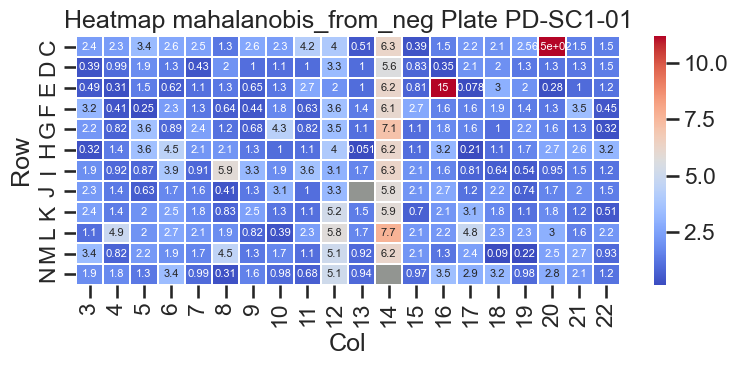

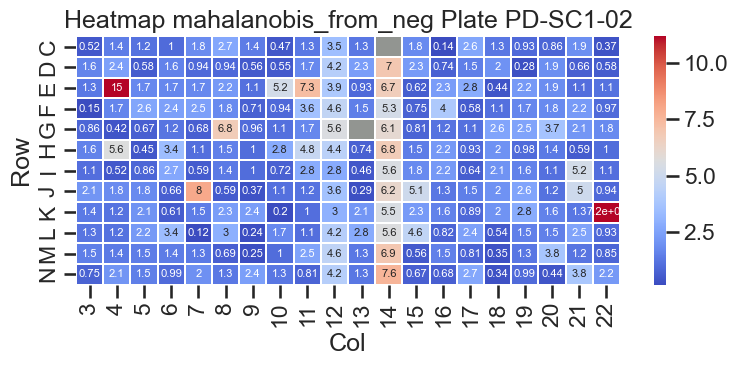

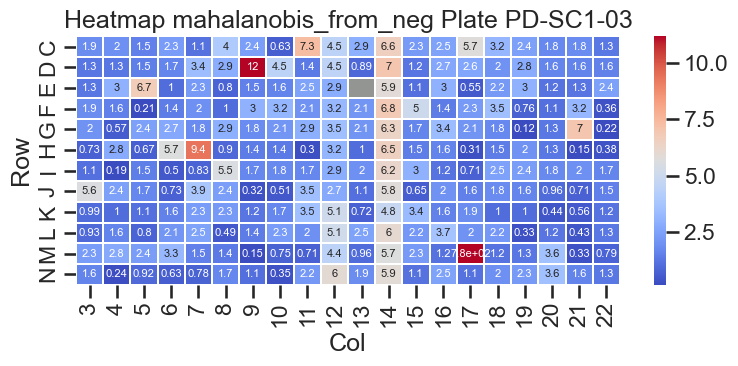

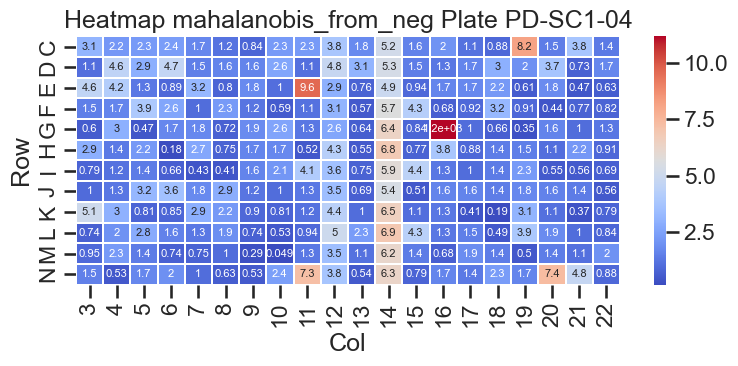

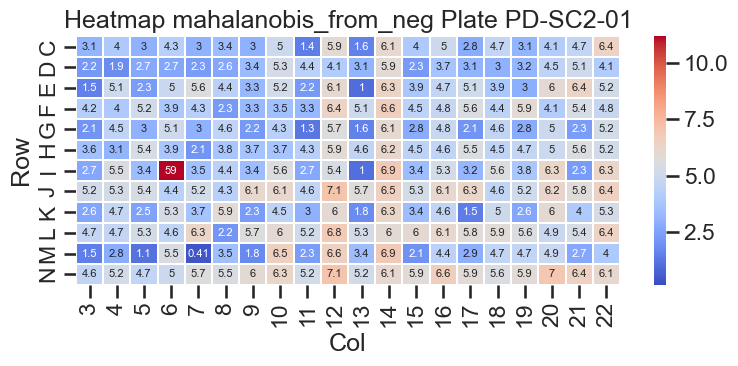

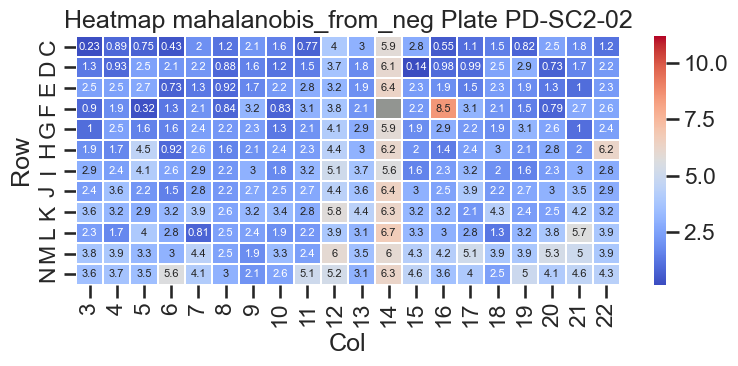

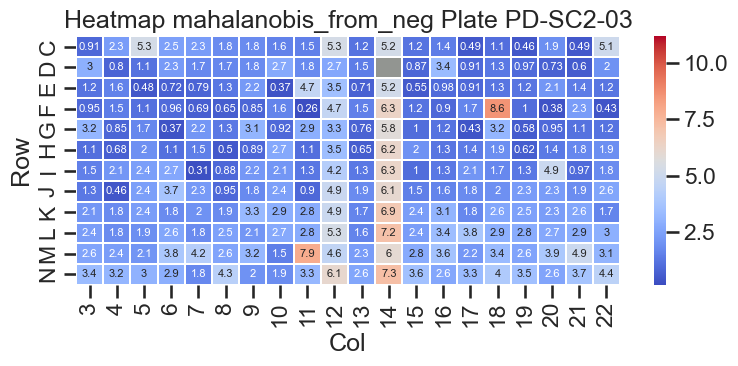

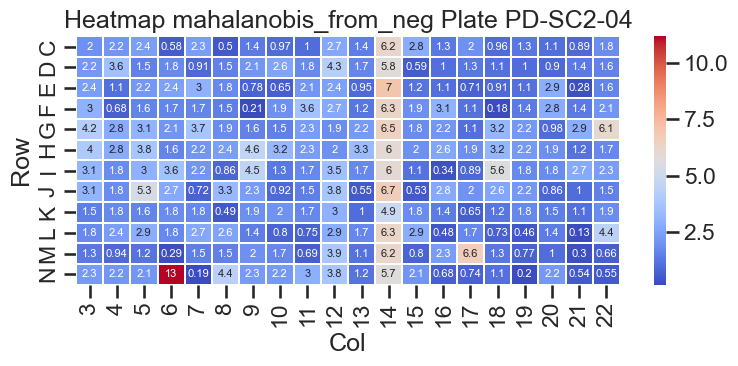

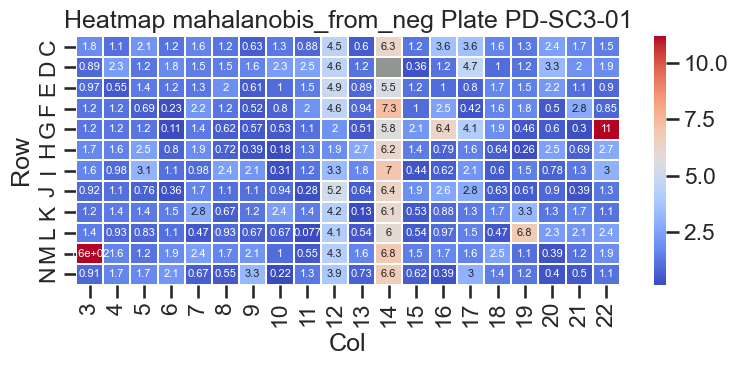

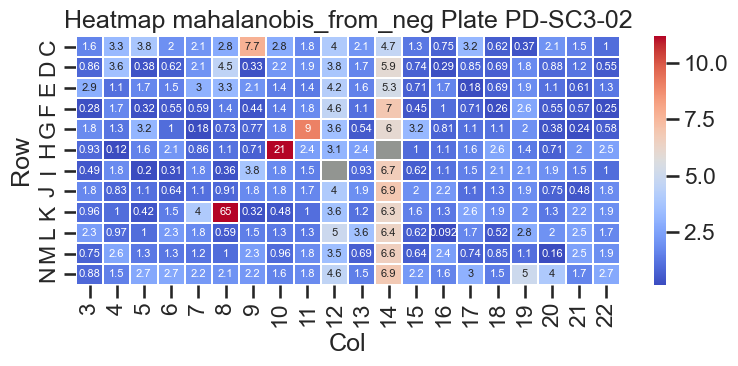

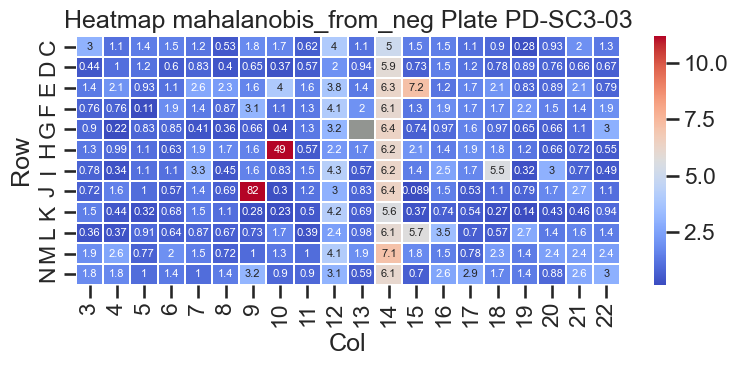

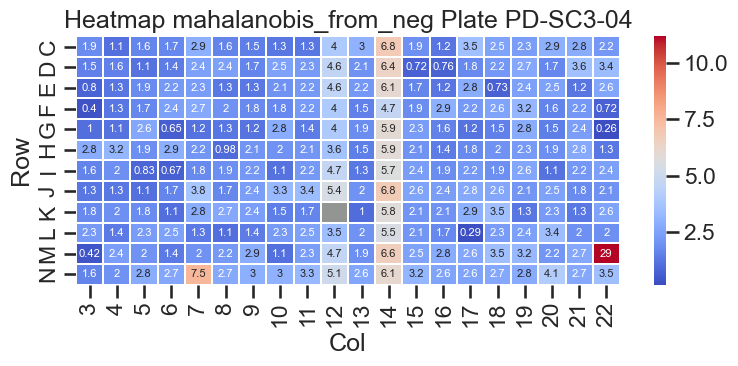

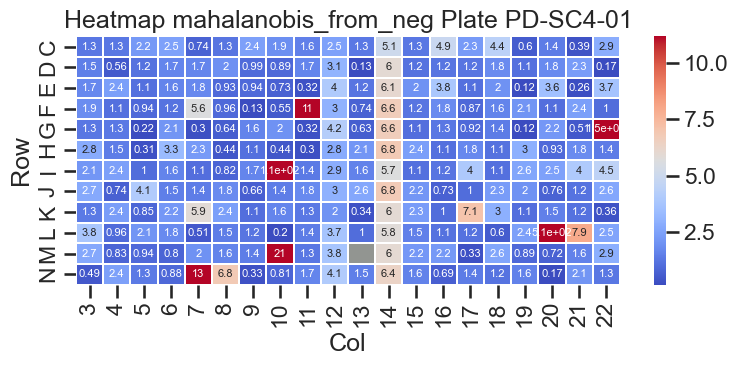

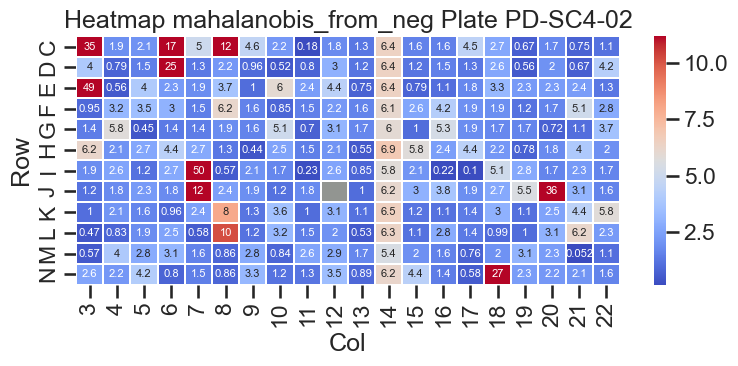

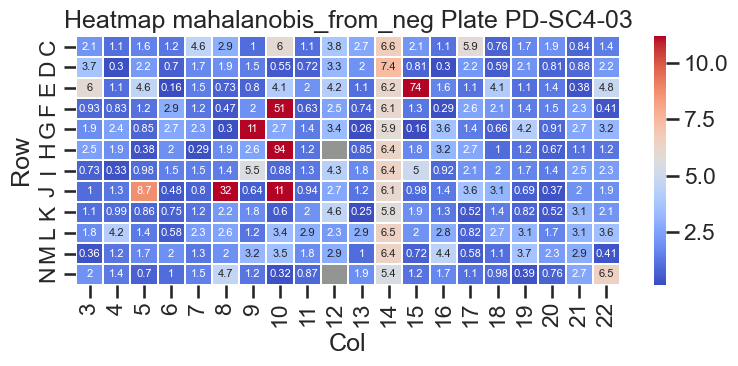

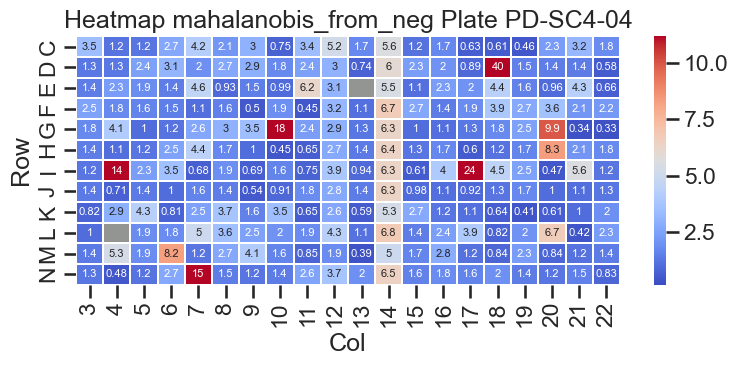

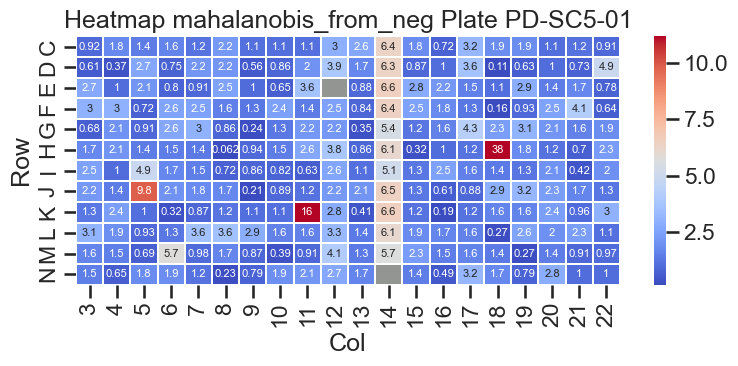

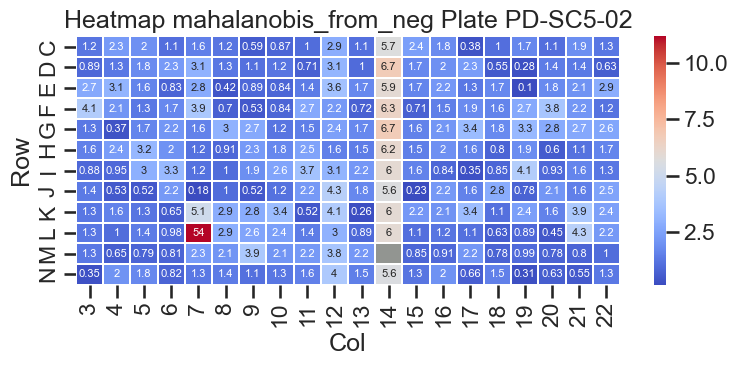

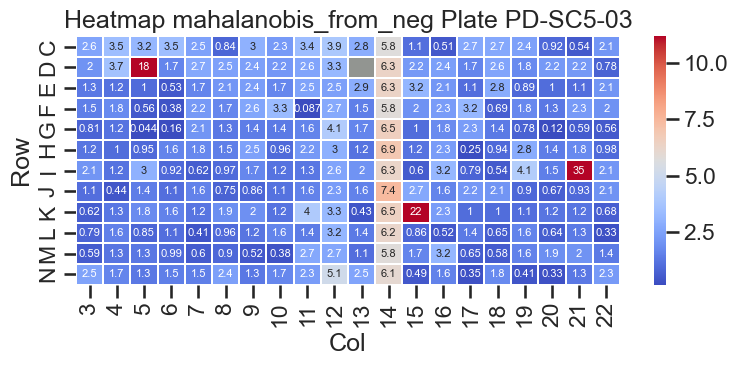

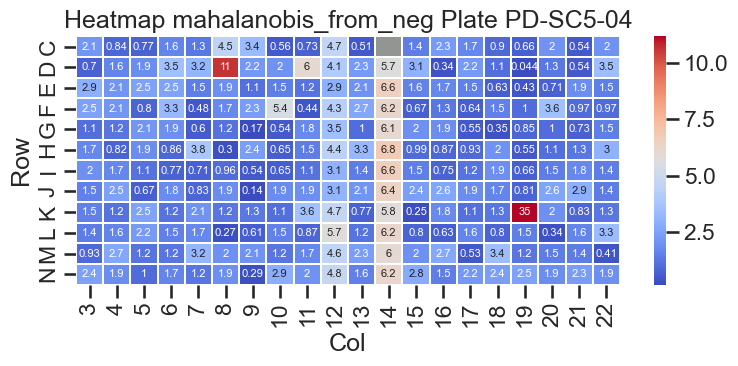

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

In [23]:
# Fit a Minimum Covariance Determinant (MCD) robust estimator to the data
robust_cov_neg = MinCovDet().fit(df_neg)
robust_cov_pos = MinCovDet().fit(df_pos)
robust_cov_pro = MinCovDet().fit(df_pro)

# Calculate the Mahalanobis distance from the negative control
mahalanobis_dist_00 = np.sqrt(robust_cov_neg.mahalanobis(df_neg))
mahalanobis_dist_01 = np.sqrt(robust_cov_neg.mahalanobis(df_pos))
mahalanobis_dist_02 = np.sqrt(robust_cov_neg.mahalanobis(df_pro))

# Calculate the Mahalanobis distance from the positive control
mahalanobis_dist_10 = np.sqrt(robust_cov_pos.mahalanobis(df_neg))
mahalanobis_dist_11 = np.sqrt(robust_cov_pos.mahalanobis(df_pos))
mahalanobis_dist_12 = np.sqrt(robust_cov_pos.mahalanobis(df_pro))

y_pl_well_neg['mahalanobis_from_pos'] = mahalanobis_dist_10
y_pl_well_pos['mahalanobis_from_pos'] = mahalanobis_dist_11
y_pl_well_pro['mahalanobis_from_pos'] = mahalanobis_dist_12

# Draw a heatmap of the Mahalanobis distance from negative control with all the data
classif_plates = X_all_cpds.reset_index()['Plate']
classif_wells = X_all_cpds.reset_index()['Well']
X_3cj_proj = lda_analysis_3cl.transform(X_all_cpds[subset_columns])

maha_dist_from_pos = pd.DataFrame()
maha_dist_from_pos['mahalanobis_from_pos'] = np.sqrt(robust_cov_pos.mahalanobis(X_3cj_proj))
maha_dist_from_pos['Plate'] = classif_plates
maha_dist_from_pos['Well'] = classif_wells
maha_dist_from_pos['tags'] = Y_all_cpds.values

maha_dist_from_pos = maha_dist_from_pos.set_index(['Plate', 'Well'])

maha_dist_from_neg = pd.DataFrame()
maha_dist_from_neg['mahalanobis_from_neg'] = np.sqrt(robust_cov_neg.mahalanobis(X_3cj_proj))
maha_dist_from_neg['Plate'] = classif_plates
maha_dist_from_neg['Well'] = classif_wells
maha_dist_from_neg['tags'] = Y_all_cpds.values

maha_dist_from_neg = maha_dist_from_neg.set_index(['Plate', 'Well'])

draw_heatmap(maha_dist_from_neg, output_path, 'mahalanobis_from_neg')


### Plate quality assessment: Z-factor and Strictly Standardized Mean Difference (SSMD) calculation based on Mahalanobis distance from Mutant + DMSO

Compared to the Z-factor SSMD is particularly useful for screens where multiple features are being evaluated. Plate quality is typically considered as appropriate with a Z-factor >0.5 or a SSMD <-1. 

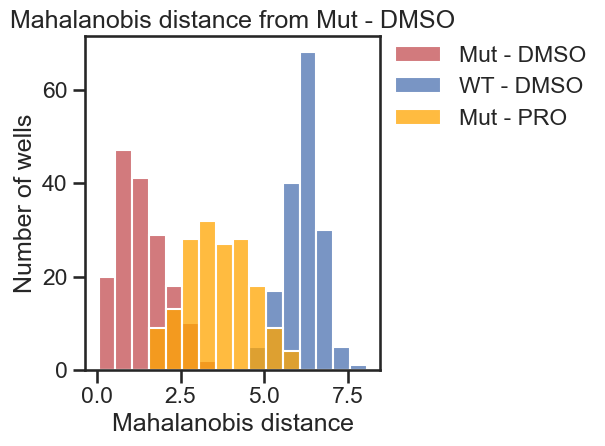

Mahalanobis : Mut - DMSO
ZFactor(Mut - DMSO vs WT - DMSO) = 0.22621042404316405
ZFactor(Mut - DMSO vs Mut - PRO) = -1.1446837262927194
ZFactor(WT - DMSO vs Mut - PRO) = -0.7319464565024483
SSMD(Mut - DMSO vs WT - DMSO) = -5.43507760468667
SSMD(Mut - DMSO vs Mut - PRO) = -1.9600782158637275
SSMD(WT - DMSO vs Mut - PRO) = -2.368169943968815


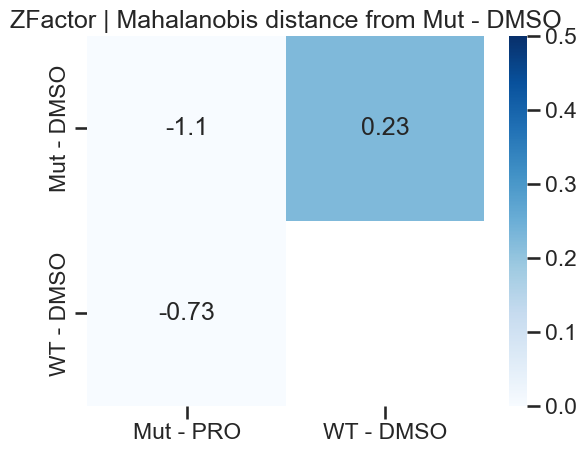

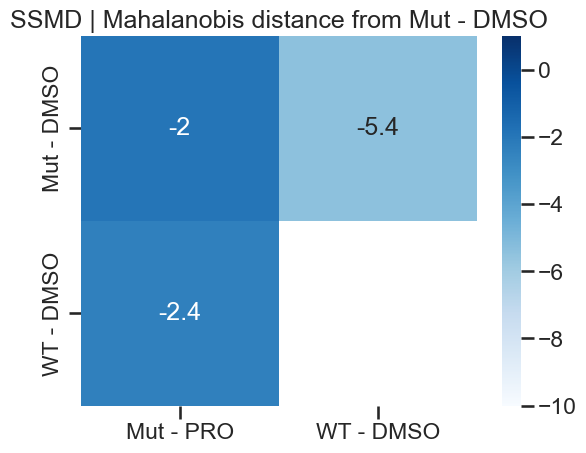

{'PD-SC1-01': 0.4067365781652842, 'PD-SC1-02': 0.10506692280087693, 'PD-SC1-03': 0.1461824759782654, 'PD-SC1-04': 0.11547077837180475, 'PD-SC2-01': -1.051757014358294, 'PD-SC2-02': 0.01765936722227257, 'PD-SC2-03': 0.22293938819665893, 'PD-SC2-04': 0.21402616469912505, 'PD-SC3-01': 0.3282622862486345, 'PD-SC3-02': 0.03086621993490346, 'PD-SC3-03': 0.4103693268793067, 'PD-SC3-04': 0.19995945881119948, 'PD-SC4-01': 0.26578806263471744, 'PD-SC4-02': 0.5564710119569298, 'PD-SC4-03': 0.19958567179752618, 'PD-SC4-04': 0.3825337496695057, 'PD-SC5-01': 0.3034407057647416, 'PD-SC5-02': 0.38899055673724126, 'PD-SC5-03': 0.21937836008253442, 'PD-SC5-04': 0.2490126914227475}


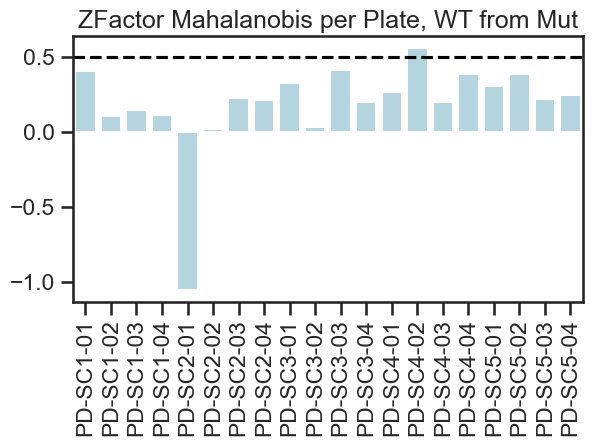

{'PD-SC1-01': -7.114582535926544, 'PD-SC1-02': -4.739974770432895, 'PD-SC1-03': -4.933927318570588, 'PD-SC1-04': -4.7680781593896056, 'PD-SC2-01': -1.6973822957791425, 'PD-SC2-02': -3.953544104855838, 'PD-SC2-03': -5.449588050476661, 'PD-SC2-04': -5.3367890159044595, 'PD-SC3-01': -6.265308861242378, 'PD-SC3-02': -4.364008060069798, 'PD-SC3-03': -7.194783512120337, 'PD-SC3-04': -5.298051038669576, 'PD-SC4-01': -5.687151908806624, 'PD-SC4-02': -9.54556795075776, 'PD-SC4-03': -5.084960696302482, 'PD-SC4-04': -6.829789707965015, 'PD-SC5-01': -6.012099418091461, 'PD-SC5-02': -6.821623137730118, 'PD-SC5-03': -5.292967363719365, 'PD-SC5-04': -5.231555838992435}


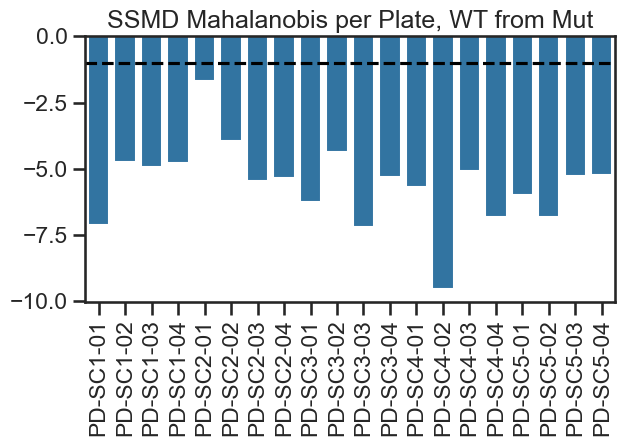

{'PD-SC1-01': -0.5572819595099494, 'PD-SC1-02': -0.6357146708901866, 'PD-SC1-03': -1.2255073081767263, 'PD-SC1-04': -0.7127382588277489, 'PD-SC2-01': -1.7179385211683074, 'PD-SC2-02': -2.302605009128811, 'PD-SC2-03': -0.5744492273986259, 'PD-SC2-04': -1.7741938989125838, 'PD-SC3-01': -0.7175113846024885, 'PD-SC3-02': -0.6628185028055222, 'PD-SC3-03': -0.754451175114228, 'PD-SC3-04': -0.3443200184162194, 'PD-SC4-01': -1.0056758424702892, 'PD-SC4-02': -0.9972979475282737, 'PD-SC4-03': -1.4095394273211426, 'PD-SC4-04': -0.8216057035716031, 'PD-SC5-01': -1.2265512648069423, 'PD-SC5-02': -1.268595091671564, 'PD-SC5-03': -2.084492713355128, 'PD-SC5-04': -1.0195471284540627}


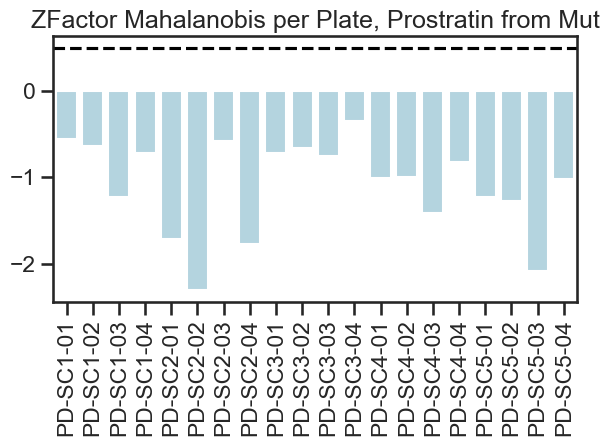

{'PD-SC1-01': -2.5417568726270274, 'PD-SC1-02': -2.5933525094963823, 'PD-SC1-03': -1.8759981959679621, 'PD-SC1-04': -2.473815849107238, 'PD-SC2-01': -1.4569869851877193, 'PD-SC2-02': -1.2817681077121996, 'PD-SC2-03': -2.612057215072662, 'PD-SC2-04': -1.5284310869152757, 'PD-SC3-01': -2.4233350352066165, 'PD-SC3-02': -2.497492325003158, 'PD-SC3-03': -2.3535114912942974, 'PD-SC3-04': -3.1520777709747794, 'PD-SC4-01': -2.113750899719576, 'PD-SC4-02': -2.046927510032507, 'PD-SC4-03': -1.7587707037755205, 'PD-SC4-04': -2.2298944099084266, 'PD-SC5-01': -1.9052860862752043, 'PD-SC5-02': -1.8474440688067042, 'PD-SC5-03': -1.3749516312070575, 'PD-SC5-04': -2.100471511156346}


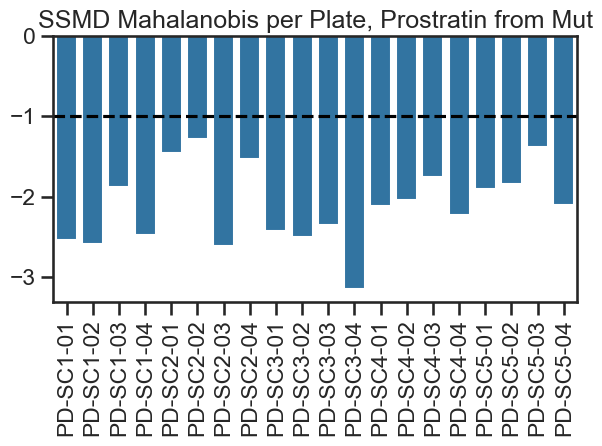

In [24]:
# Set bin width
bin_width = 0.5

# Concatenate Mahalanobis distances
maha = np.concatenate([mahalanobis_dist_00, mahalanobis_dist_01, mahalanobis_dist_02])

# Create bins
bins = np.arange(np.min(maha), np.max(maha)+bin_width, bin_width)

import seaborn as sns
sns.set_context("talk")

# Create figure and axes
fig, ax = plt.subplots()

# Plot histograms for each control group
sns.histplot(mahalanobis_dist_00, color=dict_color[ctrl_neg], label=ctrl_neg, bins=bins)
sns.histplot(mahalanobis_dist_01, color=dict_color[ctrl_pos], label=ctrl_pos, bins=bins)
sns.histplot(mahalanobis_dist_02, color=dict_color[ctrl_pro], label=ctrl_pro, bins=bins)

# Set title
plt.title('Mahalanobis distance from ' + ctrl_neg)

# Set axis labels
ax.set_xlabel('Mahalanobis distance')
ax.set_ylabel('Number of wells')

# Add legend
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Print Mahalanobis distance information
print('Mahalanobis : '+ctrl_neg)

# Print ZFactor values for each pair of control groups
print('ZFactor(' + ctrl_neg + ' vs ' + ctrl_pos+') = '+ str(compute_zfactors(mahalanobis_dist_00, mahalanobis_dist_01)))
print('ZFactor(' + ctrl_neg + ' vs ' + ctrl_pro+') = '+ str(compute_zfactors(mahalanobis_dist_00, mahalanobis_dist_02)))
print('ZFactor(' + ctrl_pos + ' vs ' + ctrl_pro+') = '+ str(compute_zfactors(mahalanobis_dist_01, mahalanobis_dist_02)))

# Print SSMD values for each pair of control groups
print('SSMD(' + ctrl_neg + ' vs ' + ctrl_pos+') = '+ str(compute_ssmd(mahalanobis_dist_00, mahalanobis_dist_01)))
print('SSMD(' + ctrl_neg + ' vs ' + ctrl_pro+') = '+ str(compute_ssmd(mahalanobis_dist_00, mahalanobis_dist_02)))
print('SSMD(' + ctrl_pos + ' vs ' + ctrl_pro+') = '+ str(compute_ssmd(mahalanobis_dist_01, mahalanobis_dist_02)))

# Create DataFrame for ZFactor values
df_zfactor_maha_neg = pd.DataFrame()
df_zfactor_maha_neg['ctrl_0'] = [ctrl_neg, ctrl_neg, ctrl_pos]
df_zfactor_maha_neg['ctrl_1'] = [ctrl_pos, ctrl_pro, ctrl_pro]
df_zfactor_maha_neg['ZFactor'] = [compute_zfactors(mahalanobis_dist_00, mahalanobis_dist_01),
                            compute_zfactors(mahalanobis_dist_00, mahalanobis_dist_02),
                            compute_zfactors(mahalanobis_dist_01, mahalanobis_dist_02)]

# Create DataFrame for SSMD values
df_ssmd_maha_neg = pd.DataFrame()
df_ssmd_maha_neg['ctrl_0'] = [ctrl_neg, ctrl_neg, ctrl_pos]
df_ssmd_maha_neg['ctrl_1'] = [ctrl_pos, ctrl_pro, ctrl_pro]
df_ssmd_maha_neg['SSMD'] = [compute_ssmd(mahalanobis_dist_00, mahalanobis_dist_01),
                            compute_ssmd(mahalanobis_dist_00, mahalanobis_dist_02),
                            compute_ssmd(mahalanobis_dist_01, mahalanobis_dist_02)]

# Create pivot table for ZFactor values
zfactor_pivot_neg = df_zfactor_maha_neg.pivot("ctrl_0", "ctrl_1", "ZFactor")

# Plot heatmap for ZFactor values
ax = sns.heatmap(zfactor_pivot_neg, cmap='Blues', annot=True, vmin=0., vmax=0.5)

# Set title
plt.title('ZFactor | Mahalanobis distance from '+ctrl_neg)

# Remove labels
ax.set_ylabel('')    
ax.set_xlabel('')

# Show plot
plt.show()

# Create pivot table for SSMD values
ssmd_pivot_neg = df_ssmd_maha_neg.pivot("ctrl_0", "ctrl_1", "SSMD")

# Plot heatmap for SSMD values
ax = sns.heatmap(ssmd_pivot_neg, cmap='Blues', annot=True, vmin=-10., vmax=1.)

# Set title
plt.title('SSMD | Mahalanobis distance from '+ctrl_neg)

# Remove labels
ax.set_ylabel('')    
ax.set_xlabel('')

# Show plot
plt.show()

### ZFactors per plate :
maha_dist_from_neg_with_plate = maha_dist_from_neg.reset_index()
dict_zfactors_plate_from_neg = zfactor_per_plate(maha_dist_from_neg_with_plate, ctrl_neg, ctrl_pos, 'mahalanobis_from_neg')
print(dict_zfactors_plate_from_neg)

f, ax = plt.subplots()
sns.barplot(x=list(dict_zfactors_plate_from_neg.keys()), y=list(dict_zfactors_plate_from_neg.values()), color='lightblue')
plt.axhline(y=0.5, color='black', linestyle='--')
plt.title('ZFactor Mahalanobis per Plate, WT from Mut')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(output_path_qc + 'zfactor_lda_3cl_per_plate_wt_from_mut' + '.pdf', bbox_inches='tight')
plt.show()

### SSMDs per plate :
dict_ssmd_plate_from_neg = ssmd_per_plate(maha_dist_from_neg_with_plate, ctrl_neg, ctrl_pos, 'mahalanobis_from_neg')
print(dict_ssmd_plate_from_neg)

f, ax = plt.subplots()
sns.barplot(x=list(dict_ssmd_plate_from_neg.keys()), y=list(dict_ssmd_plate_from_neg.values()), color='#1f77b4')
plt.axhline(y=-1.0, color='black', linestyle='--')
plt.title('SSMD Mahalanobis per Plate, WT from Mut')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(output_path_qc + 'ssmd_lda_3cl_per_plate_wt_from_mut' + '.pdf', bbox_inches='tight')
plt.show()

## ZFactor per plate :
dict_zfactors_plate_from_neg_pro = zfactor_per_plate(maha_dist_from_neg_with_plate, ctrl_neg, ctrl_pro, 'mahalanobis_from_neg')
print(dict_zfactors_plate_from_neg_pro)

f, ax = plt.subplots()
sns.barplot(x=list(dict_zfactors_plate_from_neg_pro.keys()), y=list(dict_zfactors_plate_from_neg_pro.values()), color='lightblue')
plt.axhline(y=0.5, color='black', linestyle='--')
plt.title('ZFactor Mahalanobis per Plate, Prostratin from Mut')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(output_path_qc + 'zfactor_lda_3cl_per_plate_prostratin_from_mut' + '.pdf', bbox_inches='tight')
plt.show()

### SSMDs per plate :
dict_ssmd_plate_from_neg_pro = ssmd_per_plate(maha_dist_from_neg_with_plate, ctrl_neg, ctrl_pro, 'mahalanobis_from_neg')
print(dict_ssmd_plate_from_neg_pro)

f, ax = plt.subplots()
sns.barplot(x=list(dict_ssmd_plate_from_neg_pro.keys()), y=list(dict_ssmd_plate_from_neg_pro.values()), color='#1f77b4')
plt.axhline(y=-1.0, color='black', linestyle='--')
plt.title('SSMD Mahalanobis per Plate, Prostratin from Mut')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(output_path_qc + 'ssmd_lda_3cl_per_plate_prostratin_from_mut' + '.pdf', bbox_inches='tight')
plt.show()

### Compound info & Mahalanobis distance association to dataframe used for classification

In [25]:
# Drop the 'level_0' column if it exists
if 'level_0' in X_all_cpds_lda_3cl.columns:
    X_all_cpds_lda_3cl = X_all_cpds_lda_3cl.drop('level_0', axis=1)

X_all_cpds_lda_3cl = X_all_cpds_lda_3cl.reset_index()

X_all_cpds_lda_3cl.tags.replace('Compound', 'Compound - Mut', inplace=True)

X_all_cpds_lda_3cl_cpd = link_cpds(X_all_cpds_lda_3cl,path_cpd_link)


X_all_cpds_lda_3cl_cpd = X_all_cpds_lda_3cl_cpd.reset_index()

cpd_ids, labels = zip(*X_all_cpds_lda_3cl_cpd.tags.str.split(' - '))

list_compounds = X_all_cpds_lda_3cl_cpd['CPD_ID']

list_tags_with_cpds = []

for i, cpd in enumerate(cpd_ids):
    if cpd == 'Compound':
        list_tags_with_cpds.append(str(labels[i])+';'+list_compounds[i])
    else:
        list_tags_with_cpds.append(str(cpd)+';'+str(labels[i]))

X_all_cpds_lda_3cl_cpd['tags'] = list_tags_with_cpds

X_all_cpds_lda_3cl_cpd = X_all_cpds_lda_3cl_cpd.set_index(['Plate', 'Well'])
X_all_cpds_lda_3cl_cpd['Nuclei_Number_Living'] = main_df_tot['Nuclei_Number_Living']
X_all_cpds_lda_3cl_cpd['Cell_Neurites_LengthPerNuclei_MAP2'] = main_df_tot['Cell_Neurites_LengthPerNuclei_MAP2']

print(X_all_cpds_lda_3cl_cpd.tags.value_counts())

#### Association Maha from negative control
maha_dist_from_neg = maha_dist_from_neg.reset_index()
maha_dist_from_neg.tags.replace('Compound', 'Compound - Mut', inplace=True)

df_lda_3cl_compounds_maha_from_neg = link_cpds(maha_dist_from_neg,path_cpd_link)

df_lda_3cl_compounds_maha_from_neg = df_lda_3cl_compounds_maha_from_neg.reset_index()

cpd_ids, labels = zip(*df_lda_3cl_compounds_maha_from_neg.tags.str.split(' - '))

list_compounds = df_lda_3cl_compounds_maha_from_neg['CPD_ID']

list_tags_with_cpds = []

for i, cpd in enumerate(cpd_ids):
    if cpd == 'Compound':
        list_tags_with_cpds.append(str(labels[i])+';'+list_compounds[i])
    else:
        list_tags_with_cpds.append(str(cpd)+';'+str(labels[i]))

df_lda_3cl_compounds_maha_from_neg['tags'] = list_tags_with_cpds

df_lda_3cl_compounds_maha_from_neg = df_lda_3cl_compounds_maha_from_neg.set_index(['Plate', 'Well'])
df_lda_3cl_compounds_maha_from_neg['Nuclei_Number_Living'] = main_df_tot['Nuclei_Number_Living']
df_lda_3cl_compounds_maha_from_neg['Cell_Neurites_LengthPerNuclei_MAP2'] = main_df_tot['Cell_Neurites_LengthPerNuclei_MAP2']

df_lda_3cl_compounds_maha_from_neg = df_lda_3cl_compounds_maha_from_neg.reset_index()
df_lda_3cl_compounds_maha_from_neg = df_lda_3cl_compounds_maha_from_neg[~((df_lda_3cl_compounds_maha_from_neg.Plate.isin(list_plates_to_remove_in_lda_proj)) & (df_lda_3cl_compounds_maha_from_neg.tags.isin(['WT;DMSO', 'Mut;DMSO', 'Mut;PRO'])))]
df_lda_3cl_compounds_maha_from_neg = df_lda_3cl_compounds_maha_from_neg.set_index(['Plate', 'Well'])

#### Association Maha from positive control
maha_dist_from_pos = maha_dist_from_pos.reset_index()
maha_dist_from_pos.tags.replace('Compound', 'Compound - Mut', inplace=True)

df_lda_3cl_compounds_maha_from_pos = link_cpds(maha_dist_from_pos,path_cpd_link)

df_lda_3cl_compounds_maha_from_pos = df_lda_3cl_compounds_maha_from_pos.reset_index()

cpd_ids, labels = zip(*df_lda_3cl_compounds_maha_from_pos.tags.str.split(' - '))

list_compounds = df_lda_3cl_compounds_maha_from_pos['CPD_ID']

list_tags_with_cpds = []

for i, cpd in enumerate(cpd_ids):
    if cpd == 'Compound':
        list_tags_with_cpds.append(str(labels[i])+';'+list_compounds[i])
    else:
        list_tags_with_cpds.append(str(cpd)+';'+str(labels[i]))

df_lda_3cl_compounds_maha_from_pos['tags'] = list_tags_with_cpds

df_lda_3cl_compounds_maha_from_pos = df_lda_3cl_compounds_maha_from_pos.set_index(['Plate', 'Well'])
df_lda_3cl_compounds_maha_from_pos['Nuclei_Number_Living'] = main_df_tot['Nuclei_Number_Living']
df_lda_3cl_compounds_maha_from_pos['Cell_Neurites_LengthPerNuclei_MAP2'] = main_df_tot['Cell_Neurites_LengthPerNuclei_MAP2']

df_lda_3cl_compounds_maha_from_pos = df_lda_3cl_compounds_maha_from_pos.reset_index()
df_lda_3cl_compounds_maha_from_pos = df_lda_3cl_compounds_maha_from_pos[~((df_lda_3cl_compounds_maha_from_pos.Plate.isin(list_plates_to_remove_in_lda_proj)) & (df_lda_3cl_compounds_maha_from_pos.tags.isin(['WT;DMSO', 'Mut;DMSO', 'Mut;PRO'])))]
df_lda_3cl_compounds_maha_from_pos = df_lda_3cl_compounds_maha_from_pos.set_index(['Plate', 'Well'])


Mut;PRO                     234
Mut;DMSO                    233
WT;DMSO                     231
Mut;GNE-317                   4
Mut;Bz-RS-ISer(3-Ph)-Ome      4
                           ... 
Mut;Schizandrol A             4
Mut;Trametinib                4
Mut;Palmatine                 4
Mut;Vinpocetine               4
Mut;Timosaponin A3            3
Name: tags, Length: 1023, dtype: int64


### Export files

In [27]:
# Copy data
df_lda_3cl_compounds_maha_all_raw = df_lda_3cl_compounds_maha_from_neg.copy()
df_lda_3cl_compounds_maha_all_raw['mahalanobis_from_pos'] = df_lda_3cl_compounds_maha_from_pos['mahalanobis_from_pos']

df_lda_3cl_compounds_maha_all_normed = df_lda_3cl_compounds_maha_all_raw.copy()

# Add features used during classification TO DO: UPDATE to subset_columns
for f in subset_columns:
    df_lda_3cl_compounds_maha_all_raw[f] = main_df_tot[f]
    df_lda_3cl_compounds_maha_all_normed[f] = X_all_cpds[f]

# Move several columns to the front of the dataframe for easier visibility
cols = list(df_lda_3cl_compounds_maha_all_raw.columns)
cols.insert(6, cols.pop(cols.index('mahalanobis_from_pos')))
cols.insert(6, cols.pop(cols.index('mahalanobis_from_neg')))
cols.insert(7, cols.pop(cols.index('Nuclei_Number_Living')))
cols.insert(7, cols.pop(cols.index('Cell_Neurites_LengthPerNuclei_MAP2')))
df_lda_3cl_compounds_maha_all_raw = df_lda_3cl_compounds_maha_all_raw[cols]

cols = list(df_lda_3cl_compounds_maha_all_normed.columns)
cols.insert(6, cols.pop(cols.index('mahalanobis_from_pos')))
cols.insert(6, cols.pop(cols.index('mahalanobis_from_neg')))
cols.insert(7, cols.pop(cols.index('Nuclei_Number_Living')))
cols.insert(7, cols.pop(cols.index('Cell_Neurites_LengthPerNuclei_MAP2')))
df_lda_3cl_compounds_maha_all_normed = df_lda_3cl_compounds_maha_all_normed[cols]

display(df_lda_3cl_compounds_maha_all_raw)
display(df_lda_3cl_compounds_maha_all_normed)

# Save data
df_lda_3cl_compounds_maha_all_raw.to_csv(output_path_csv+'after_classification_mahalanobis_distances_not_normalized.csv')
df_lda_3cl_compounds_maha_all_normed.to_csv(output_path_csv+'after_classification_mahalanobis_distances_normalized.csv')

tags  Concentration  BATCH_ID  \
Plate     Well                                                     
PD-SC1-01 C03   Mut;Quetiapine Fumarate       0.000005  S1763-01   
          J15           Mut;Disulfiram        0.000005  S1680-01   
          J16             Mut;Tamoxifen       0.000005  S1238-01   
          J17     Mut;Mosapride Citrate       0.000005  S1385-01   
          J18          Mut;Temozolomide       0.000005  S1237-01   
...                                 ...            ...       ...   
PD-SC5-04 J17                Mut;SC-560       0.000005  S6686-01   
          J16               Mut;PLX5622       0.000005  S8874-01   
          J15            Mut;WAY-327360       0.000005  P2523-01   
          I03            Mut;WAY-300678       0.000005  P2152-01   
          C03      Mut;Palonosetron HCl       0.000005  S3050-01   

                             CPD_ID                                   Target  \
Plate     Well                                                                 
PD-SC1-01 C03   Quetiapine Fumarate                        Dopamine Receptor   
          J15           Disulfiram                             Dehydrogenase   
          J16             Tamoxifen  Estrogen/progestogen Receptor#Autophagy   
          J17     Mosapride Citrate                            5-HT Receptor   
          J18          Temozolomide              DNA/RNA Synthesis#Autophagy   
...                             ...                                      ...   
PD-SC5-04 J17                SC-560                                      COX   
          J16               PLX5622                                   CSF-1R   
          J15            WAY-327360                          calcium channel   
          I03            WAY-300678                           Anti-infection   
          C03      Palonosetron HCl                            5-HT Receptor   

                mahalanobis_from_pos  mahalanobis_from_neg  \
Plate     Well                                               
PD-SC1-01 C03              21.830963              2.374931   
          J15              10.463071              2.077087   
          J16               9.475535              2.704952   
          J17              13.108549              1.159574   
          J18              10.173646              2.197924   
...                              ...                   ...   
PD-SC5-04 J17              19.545441              1.902435   
          J16              13.564729              2.630212   
          J15              13.067009              2.413106   
          I03              10.864707              1.987437   
          C03              15.197914              2.124259   

                Cell_Neurites_LengthPerNuclei_MAP2  Nuclei_Number_Living  \
Plate     Well                                                             
PD-SC1-01 C03                              206.287                4444.0   
          J15                              329.895                2499.0   
          J16                              387.463                2073.0   
          J17                              295.102                2595.0   
          J18                              294.073                2657.0   
...                                            ...                   ...   
PD-SC5-04 J17                              219.681                2816.0   
          J16                              213.309                2826.0   
          J15                              215.783                2942.0   
          I03                              202.841                2818.0   
          C03                              180.526                3104.0   

                Nuclei_Surface_MeanArea  ...  \
Plate     Well                           ...   
PD-SC1-01 C03                   772.547  ...   
          J15                   763.476  ...   
          J16                   785.412  ...   
          J17                   846.615  ...   
          J18            

tags  Concentration  BATCH_ID  \
Plate     Well                                                     
PD-SC1-01 C03   Mut;Quetiapine Fumarate       0.000005  S1763-01   
          J15           Mut;Disulfiram        0.000005  S1680-01   
          J16             Mut;Tamoxifen       0.000005  S1238-01   
          J17     Mut;Mosapride Citrate       0.000005  S1385-01   
          J18          Mut;Temozolomide       0.000005  S1237-01   
...                                 ...            ...       ...   
PD-SC5-04 J17                Mut;SC-560       0.000005  S6686-01   
          J16               Mut;PLX5622       0.000005  S8874-01   
          J15            Mut;WAY-327360       0.000005  P2523-01   
          I03            Mut;WAY-300678       0.000005  P2152-01   
          C03      Mut;Palonosetron HCl       0.000005  S3050-01   

                             CPD_ID                                   Target  \
Plate     Well                                                                 
PD-SC1-01 C03   Quetiapine Fumarate                        Dopamine Receptor   
          J15           Disulfiram                             Dehydrogenase   
          J16             Tamoxifen  Estrogen/progestogen Receptor#Autophagy   
          J17     Mosapride Citrate                            5-HT Receptor   
          J18          Temozolomide              DNA/RNA Synthesis#Autophagy   
...                             ...                                      ...   
PD-SC5-04 J17                SC-560                                      COX   
          J16               PLX5622                                   CSF-1R   
          J15            WAY-327360                          calcium channel   
          I03            WAY-300678                           Anti-infection   
          C03      Palonosetron HCl                            5-HT Receptor   

                mahalanobis_from_pos  mahalanobis_from_neg  \
Plate     Well                                               
PD-SC1-01 C03              21.830963              2.374931   
          J15              10.463071              2.077087   
          J16               9.475535              2.704952   
          J17              13.108549              1.159574   
          J18              10.173646              2.197924   
...                              ...                   ...   
PD-SC5-04 J17              19.545441              1.902435   
          J16              13.564729              2.630212   
          J15              13.067009              2.413106   
          I03              10.864707              1.987437   
          C03              15.197914              2.124259   

                Cell_Neurites_LengthPerNuclei_MAP2  Nuclei_Number_Living  \
Plate     Well                                                             
PD-SC1-01 C03                            -0.620760                4444.0   
          J15                             7.550799                2499.0   
          J16                            11.356542                2073.0   
          J17                             5.250680                2595.0   
          J18                             5.182654                2657.0   
...                                            ...                   ...   
PD-SC5-04 J17                             6.019025                2816.0   
          J16                             5.051511                2826.0   
          J15                             5.427159                2942.0   
          I03                             3.462067                2818.0   
          C03                             0.073793                3104.0   

                Nuclei_Surface_MeanArea  ...  \
Plate     Well                           ...   
PD-SC1-01 C03                 -0.632966  ...   
          J15                 -0.906598  ...   
          J16                 -0.244885  ...   
          J17                  1.601343  ...   
          J18            

### Visualize hits

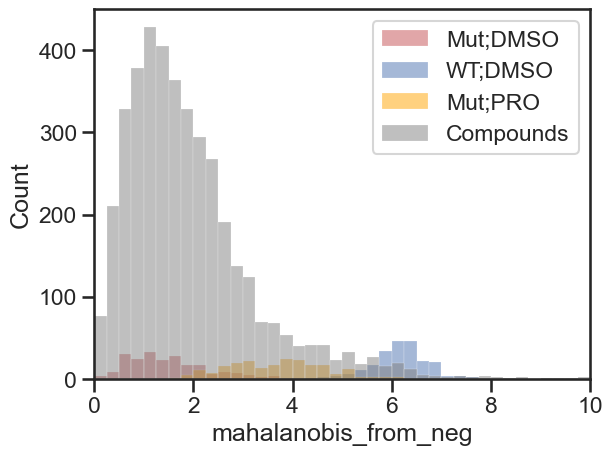

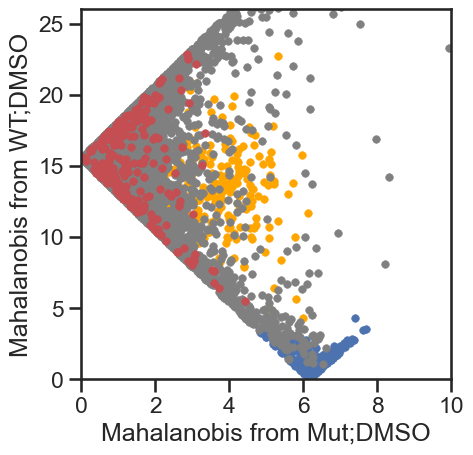

In [ ]:
df_lda_3cl_compounds_maha_from_neg_dmso_neg = df_lda_3cl_compounds_maha_from_neg[df_lda_3cl_compounds_maha_from_neg.tags.str.contains('Mut;DMSO')]
df_lda_3cl_compounds_maha_from_neg_dmso_pos = df_lda_3cl_compounds_maha_from_neg[df_lda_3cl_compounds_maha_from_neg.tags.str.contains('WT;DMSO')]
df_lda_3cl_compounds_maha_from_neg_dmso_pro = df_lda_3cl_compounds_maha_from_neg[df_lda_3cl_compounds_maha_from_neg.tags.str.contains('PRO')]
df_lda_3cl_compounds_maha_from_neg_dmso_cpds = df_lda_3cl_compounds_maha_from_neg[(df_lda_3cl_compounds_maha_from_neg.tags.str.contains('Mut')) \
& ~(df_lda_3cl_compounds_maha_from_neg.tags.str.contains('DMSO'))& ~(df_lda_3cl_compounds_maha_from_neg.tags.str.contains('PRO'))]

df_lda_3cl_compounds_maha_from_pos_dmso_neg = df_lda_3cl_compounds_maha_from_pos[df_lda_3cl_compounds_maha_from_pos.tags.str.contains('Mut;DMSO')]
df_lda_3cl_compounds_maha_from_pos_dmso_pos = df_lda_3cl_compounds_maha_from_pos[df_lda_3cl_compounds_maha_from_pos.tags.str.contains('WT;DMSO')]
df_lda_3cl_compounds_maha_from_pos_dmso_pro = df_lda_3cl_compounds_maha_from_pos[df_lda_3cl_compounds_maha_from_pos.tags.str.contains('PRO')]
df_lda_3cl_compounds_maha_from_pos_dmso_cpds = df_lda_3cl_compounds_maha_from_pos[(df_lda_3cl_compounds_maha_from_pos.tags.str.contains('Mut')) \
& ~(df_lda_3cl_compounds_maha_from_pos.tags.str.contains('DMSO'))& ~(df_lda_3cl_compounds_maha_from_pos.tags.str.contains('PRO'))]

# Histogram of Mahalanobis distances per categroy from Mutant + DMSO

binwidth = 0.25
bins = np.arange(-5, 50 + binwidth, binwidth)

f0, ax0 = plt.subplots()
sns.histplot(x=df_lda_3cl_compounds_maha_from_neg_dmso_neg['mahalanobis_from_neg'], color='#C44E52', bins=bins, alpha=0.5, 
             label='Mut;DMSO')
sns.histplot(x=df_lda_3cl_compounds_maha_from_neg_dmso_pos['mahalanobis_from_neg'], color='#4C72B0', bins=bins, alpha=0.5, 
             label='WT;DMSO')
sns.histplot(x=df_lda_3cl_compounds_maha_from_neg_dmso_pro['mahalanobis_from_neg'], color='orange', bins=bins, alpha=0.5, 
             label='Mut;PRO')
sns.histplot(x=df_lda_3cl_compounds_maha_from_neg_dmso_cpds['mahalanobis_from_neg'], color='gray', bins=bins, alpha=0.5, 
             label='Compounds')
ax0.set_xlim(left=0, right=10)
plt.legend()
plt.savefig(output_path + '3-Class-LDA_Histogram_Compounds_Mahalanobis' + '.pdf', bbox_inches='tight')
plt.show()

# Vulcano plot of Mahalanobis distances

sns.set_context("talk") 
ax = sns.scatterplot(x=df_lda_3cl_compounds_maha_from_neg_dmso_pro['mahalanobis_from_neg'], 
                y=df_lda_3cl_compounds_maha_from_pos_dmso_pro['mahalanobis_from_pos'], color='orange', s=30, edgecolor=None)
ax = sns.scatterplot(x=df_lda_3cl_compounds_maha_from_neg_dmso_pos['mahalanobis_from_neg'], 
                y=df_lda_3cl_compounds_maha_from_pos_dmso_pos['mahalanobis_from_pos'], color='#4C72B0', s=30, edgecolor=None)
ax = sns.scatterplot(x=df_lda_3cl_compounds_maha_from_neg_dmso_cpds['mahalanobis_from_neg'], 
                y=df_lda_3cl_compounds_maha_from_pos_dmso_cpds['mahalanobis_from_pos'], color='gray', s=30, edgecolor=None)
ax = sns.scatterplot(x=df_lda_3cl_compounds_maha_from_neg_dmso_neg['mahalanobis_from_neg'], 
                y=df_lda_3cl_compounds_maha_from_pos_dmso_neg['mahalanobis_from_pos'], color='#C44E52', s=30, edgecolor=None)

ax.set_xlim(0,10)
ax.set_ylim(0,26)
ax.set_box_aspect(1)
ax.set_xlabel('Mahalanobis from Mut;DMSO')
ax.set_ylabel('Mahalanobis from WT;DMSO')
plt.savefig(output_path + '3-Class-LDA_Volcano_Compounds_Mahalanobis' + '.pdf', bbox_inches='tight')
plt.show()
